In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/subset-20/subset_20/underhang_ball_test.csv
/kaggle/input/subset-20/subset_20/normal_test.csv
/kaggle/input/subset-20/subset_20/horizontal_test.csv
/kaggle/input/subset-20/subset_20/overhang_ball_test.csv
/kaggle/input/subset-20/subset_20/underhang_ball_train.csv
/kaggle/input/subset-20/subset_20/overhang_outer_train.csv
/kaggle/input/subset-20/subset_20/underhang_outer_train.csv
/kaggle/input/subset-20/subset_20/overhang_ball_train.csv
/kaggle/input/subset-20/subset_20/overhang_cage_test.csv
/kaggle/input/subset-20/subset_20/vertical_test.csv
/kaggle/input/subset-20/subset_20/horizontal_train.csv
/kaggle/input/subset-20/subset_20/imbalance_test.csv
/kaggle/input/subset-20/subset_20/vertical_train.csv
/kaggle/input/subset-20/subset_20/overhang_cage_train.csv
/kaggle/input/subset-20/subset_20/normal_train.csv
/kaggle/input/subset-20/subset_20/imbalance_train.csv
/kaggle/input/subset-20/subset_20/underhang_cage_train.csv
/kaggle/input/subset-20/subset_20/underhang_cage_test

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from scipy.stats import skew, kurtosis
from scipy.signal import welch
from scipy import stats,signal
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier
import xgboost as xgb
from xgboost import XGBClassifier

In [3]:
def extract_features(signal):
    mean = np.mean(signal)
    var = np.var(signal)
    skewness = skew(signal)
    kurt = kurtosis(signal)
    freq, psd = welch(signal)
    dominant_freq = freq[np.argmax(psd)]
    return [mean, var, skewness, kurt, dominant_freq]
def feature_extraction_window(data,fault,step_size):
    window_length = 125000    
    results = []
    features_list = ["Tachometer", "UBA_axial", "UBA_radial", "UBA_tangential", "OBA_axial", "OBA_radial", "OBA_tangential", "Microphone"]
    for start in range(0, len(data) - window_length + 1, step_size):
        window = data.iloc[start:start + window_length]
        window_features = {}
        for column in features_list:
            # Extract signal values
            signal = window[column].values
            
            # Compute features
            features = extract_features(signal)
            window_features.update({
                f"{column}_Mean": features[0],
                f"{column}_Variance": features[1],
                f"{column}_Skewness": features[2],
                f"{column}_Kurtosis": features[3],
                f"{column}_Dominant_Frequency": features[4],
            })
        results.append(window_features)
    
    features_df = pd.DataFrame(results)
    features_df['Fault'] = fault
    return pd.concat([df,features_df],ignore_index=True)

In [4]:
def plot_data(data,plot_name):
    fig, axs = plt.subplots(8, sharex=False, sharey=False, figsize=(15, 15))
    fig.suptitle(f'All Features of {plot_name}')
    
    for idx, col in enumerate(data.columns):
        axs[idx].plot(data[col])  
        axs[idx].set_title(f'{col} Feature')  
    plt.tight_layout()
    plt.show()

In [5]:
horizontal_test = pd.read_csv("/kaggle/input/subset-20/subset_20/horizontal_test.csv")
horizontal_train = pd.read_csv("/kaggle/input/subset-20/subset_20/horizontal_train.csv")
vertical_test = pd.read_csv("/kaggle/input/subset-20/subset_20/vertical_test.csv")
vertical_train = pd.read_csv("/kaggle/input/subset-20/subset_20/vertical_train.csv")
imbalance_test = pd.read_csv("/kaggle/input/subset-20/subset_20/imbalance_test.csv")
imbalance_train = pd.read_csv("/kaggle/input/subset-20/subset_20/imbalance_train.csv")
normal_test = pd.read_csv("/kaggle/input/subset-20/subset_20/normal_test.csv")
normal_train = pd.read_csv("/kaggle/input/subset-20/subset_20/normal_train.csv")
overhang_ball_test = pd.read_csv("/kaggle/input/subset-20/subset_20/overhang_ball_test.csv")
overhang_ball_train = pd.read_csv("/kaggle/input/subset-20/subset_20/overhang_ball_train.csv")
overhang_cage_test = pd.read_csv("/kaggle/input/subset-20/subset_20/overhang_cage_test.csv")
overhang_cage_train = pd.read_csv("/kaggle/input/subset-20/subset_20/overhang_cage_train.csv")
overhang_outer_test = pd.read_csv("/kaggle/input/subset-20/subset_20/overhang_outer_test.csv")
overhang_outer_train = pd.read_csv("/kaggle/input/subset-20/subset_20/overhang_outer_train.csv")
underhang_ball_test = pd.read_csv("/kaggle/input/subset-20/subset_20/underhang_ball_test.csv")
underhang_ball_train = pd.read_csv("/kaggle/input/subset-20/subset_20/underhang_ball_train.csv")
underhang_cage_test = pd.read_csv("/kaggle/input/subset-20/subset_20/underhang_cage_test.csv")
underhang_cage_train = pd.read_csv("/kaggle/input/subset-20/subset_20/underhang_cage_train.csv")
underhang_outer_test = pd.read_csv("/kaggle/input/subset-20/subset_20/underhang_outer_test.csv")
underhang_outer_train = pd.read_csv("/kaggle/input/subset-20/subset_20/underhang_outer_train.csv")

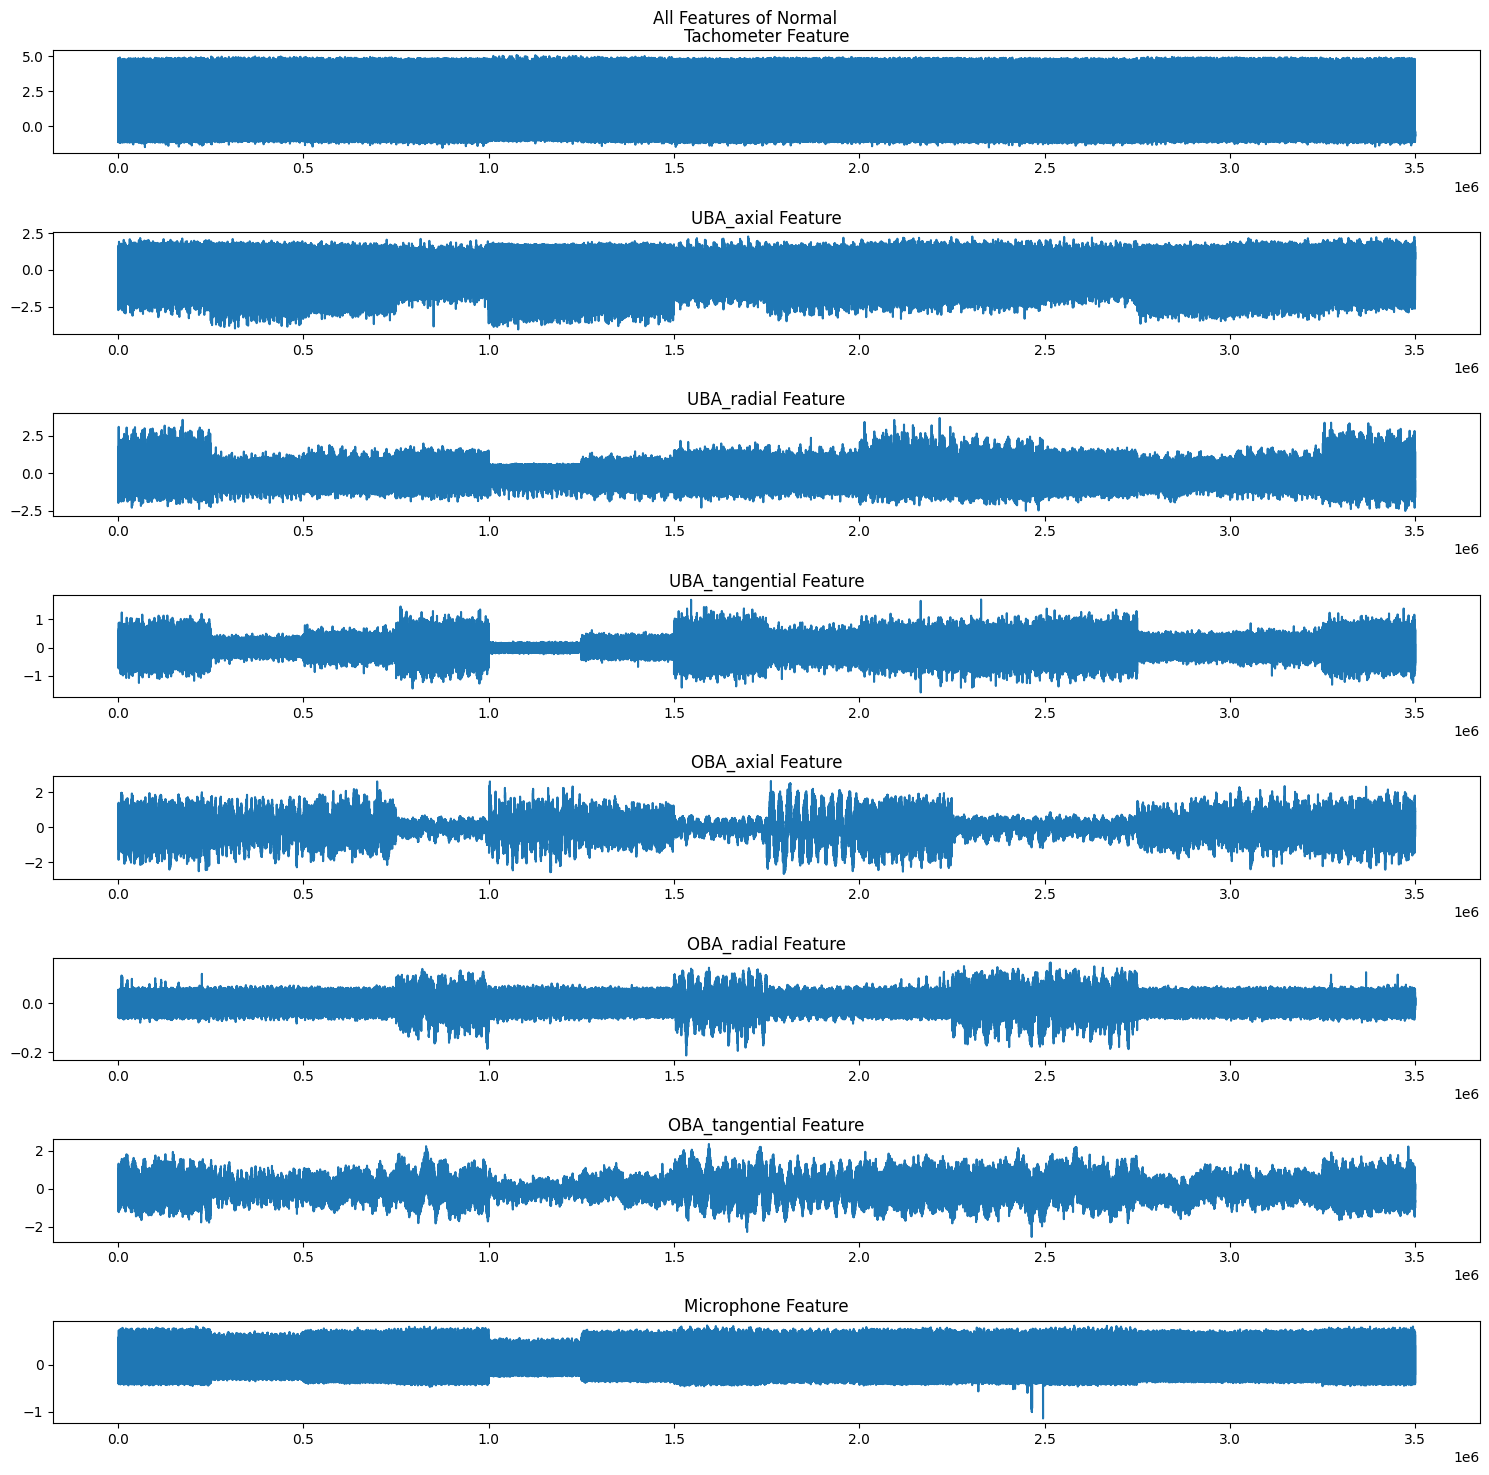

In [7]:
plot_data(normal_train,"Normal")

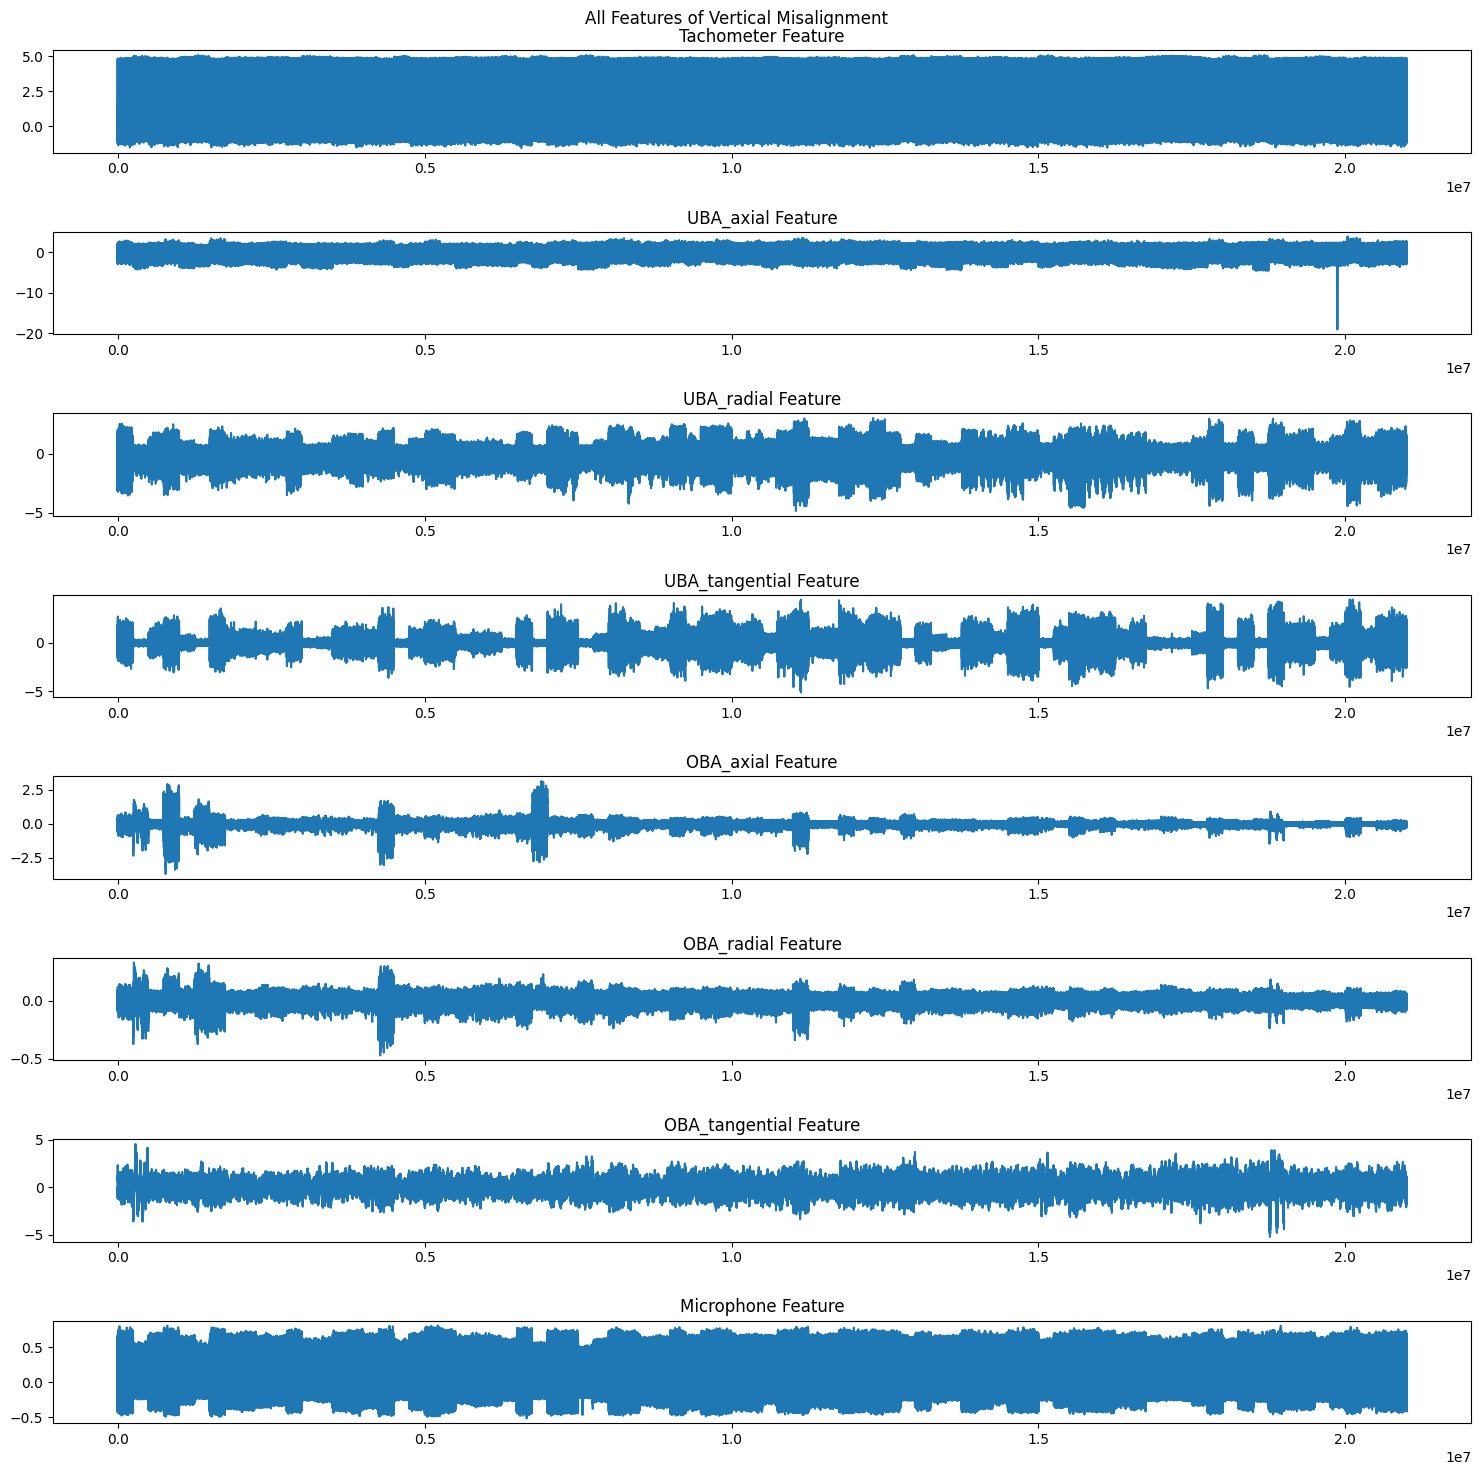

In [8]:
plot_data(vertical_train,"Vertical Misalignment")

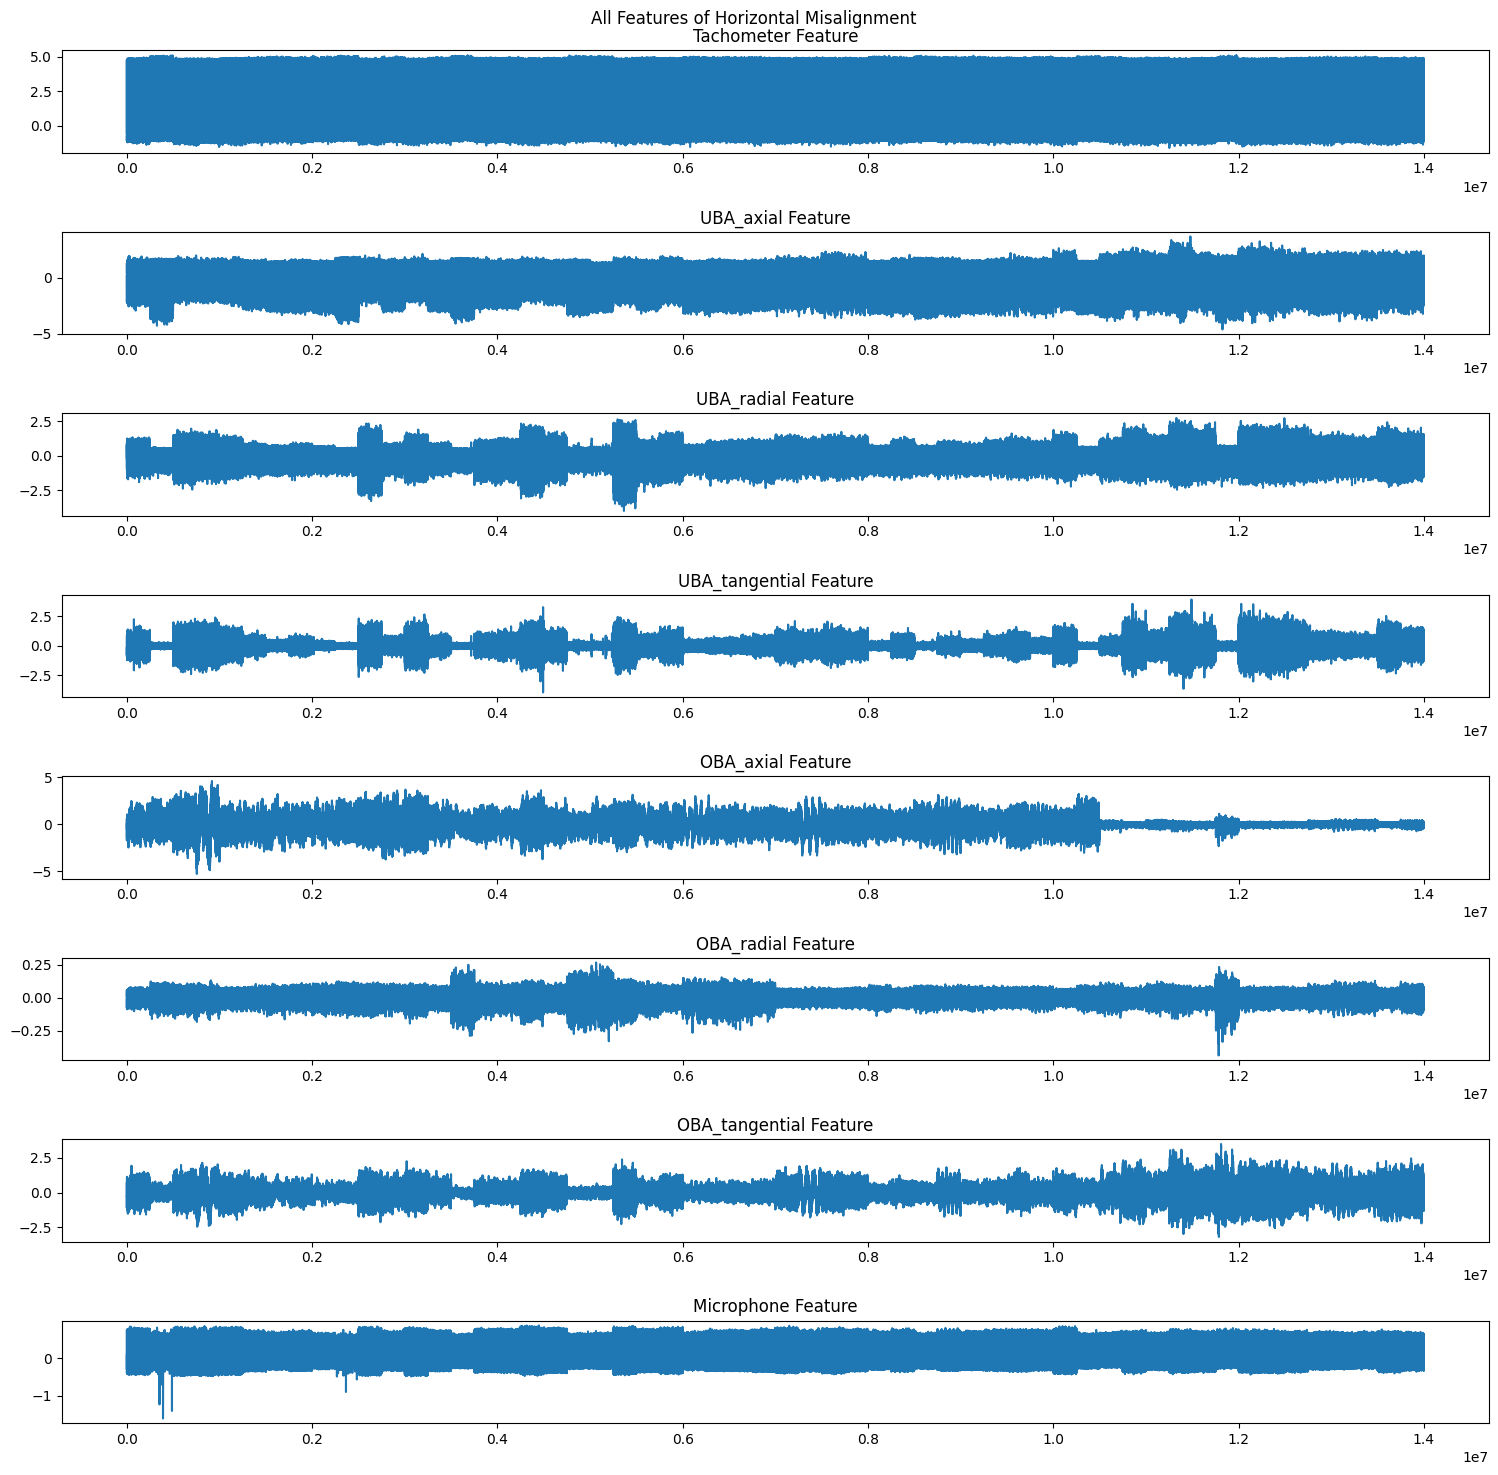

In [6]:
plot_data(horizontal_train,"Horizontal Misalignment")

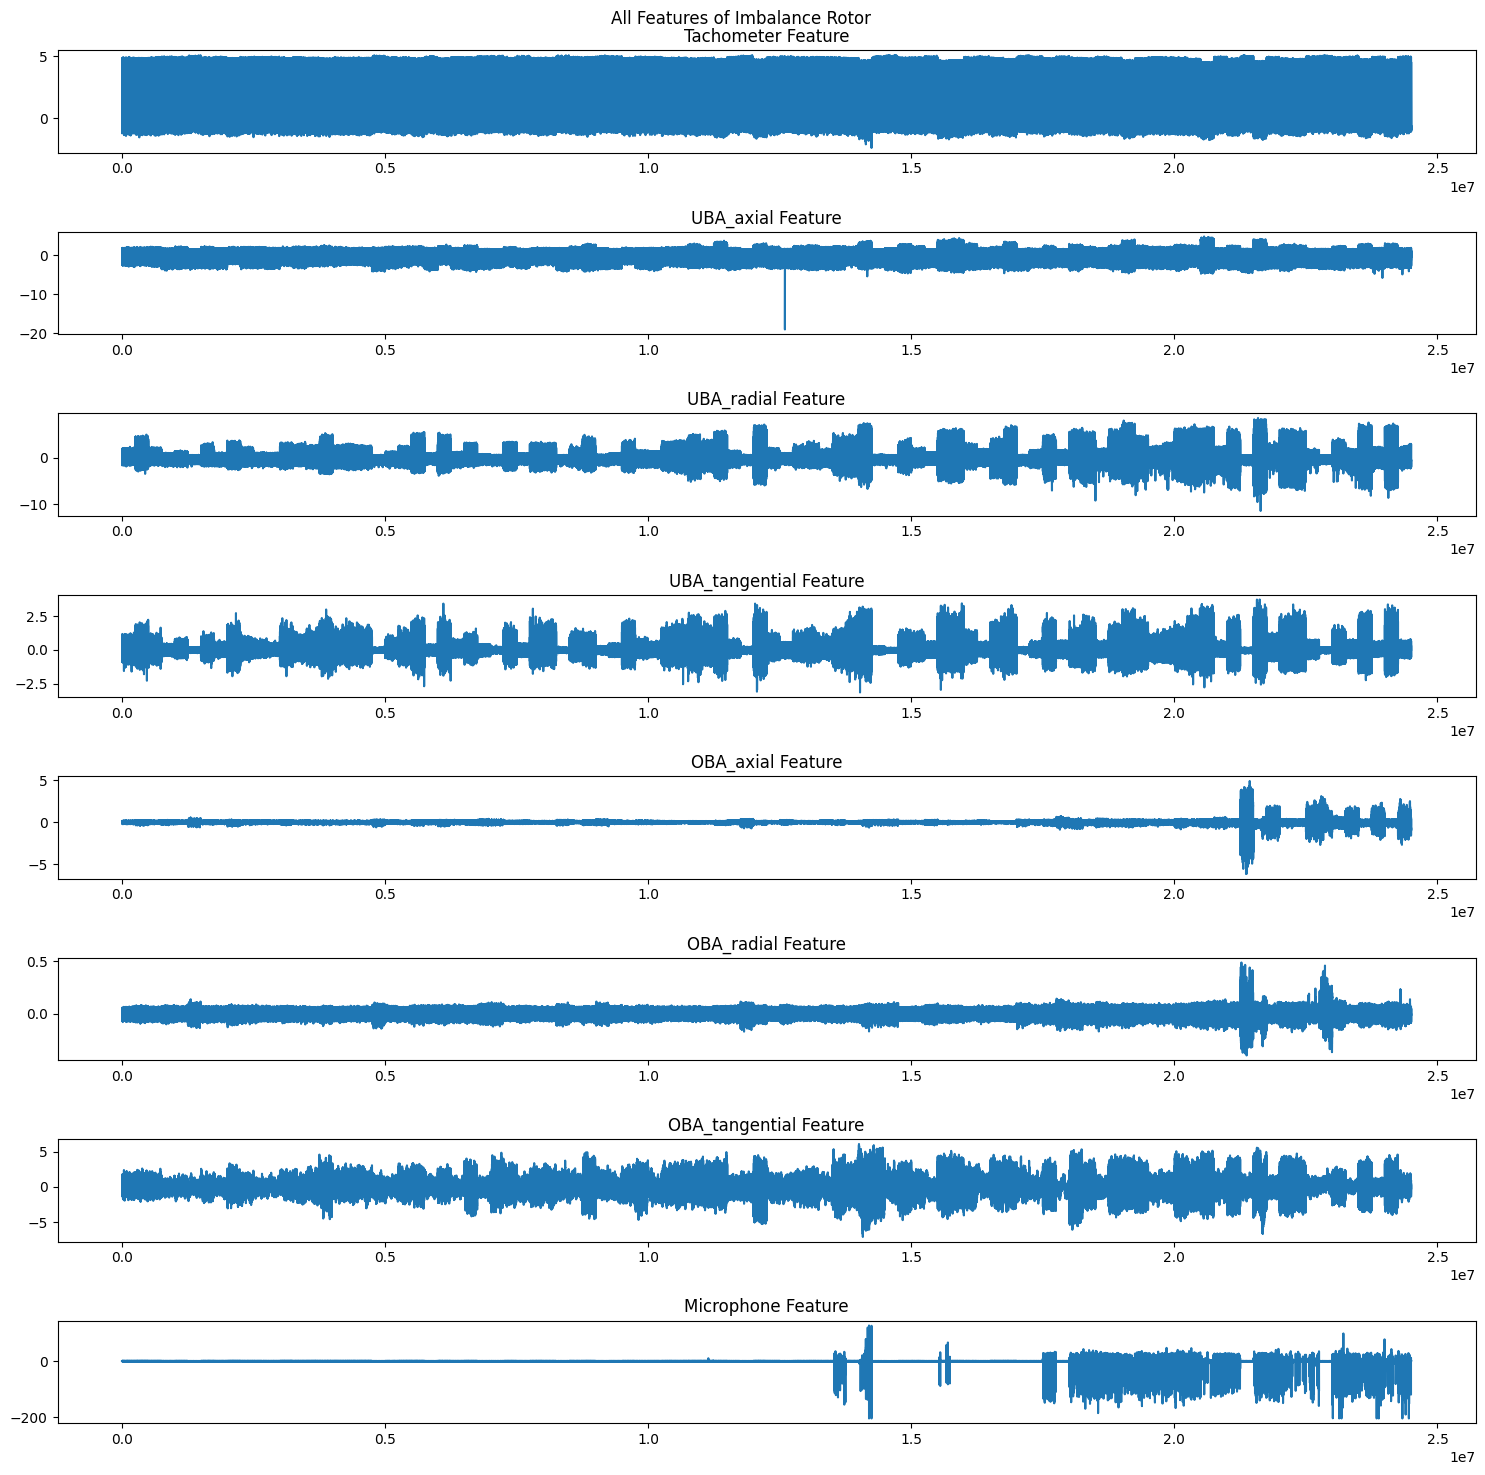

In [5]:
plot_data(imbalance_train,"Imbalance Rotor")

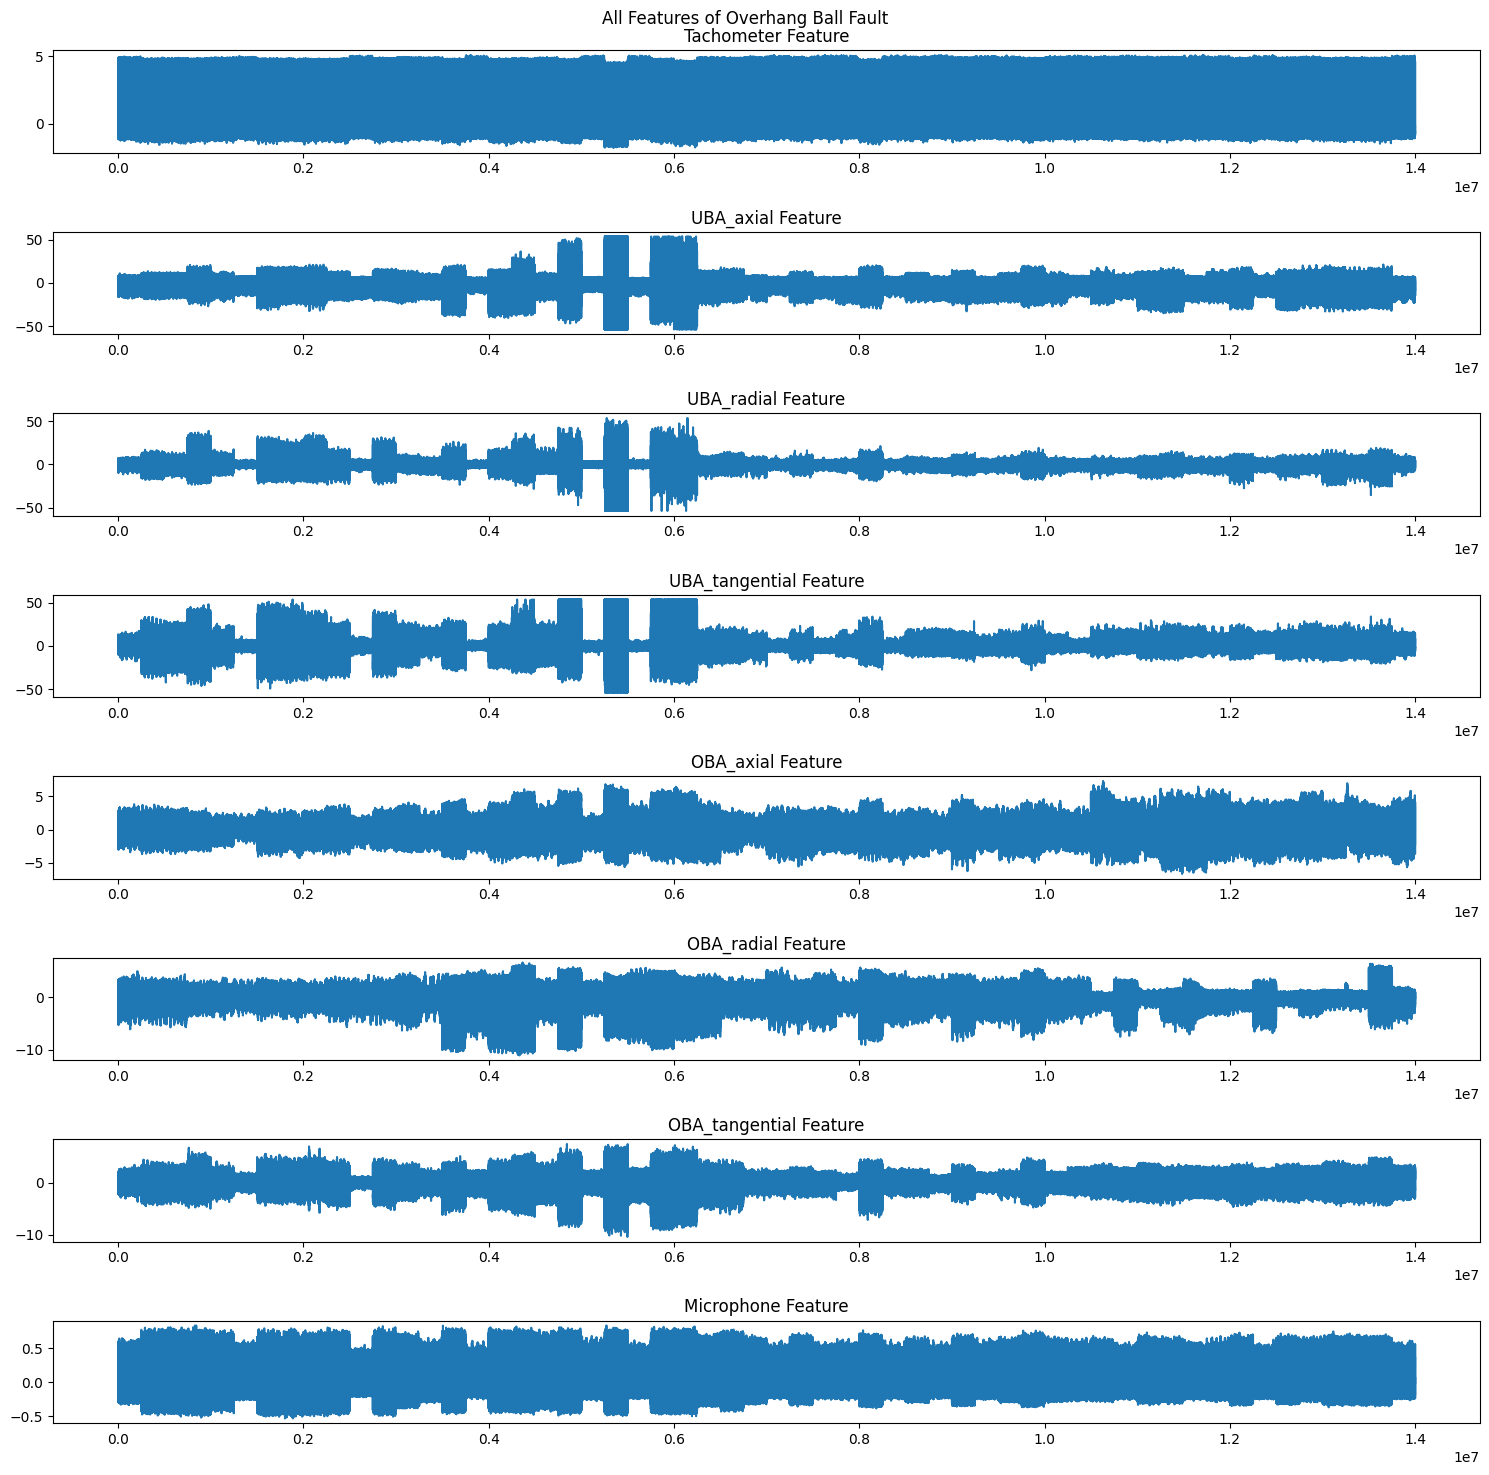

In [5]:
plot_data(overhang_ball_train,"Overhang Ball Fault")

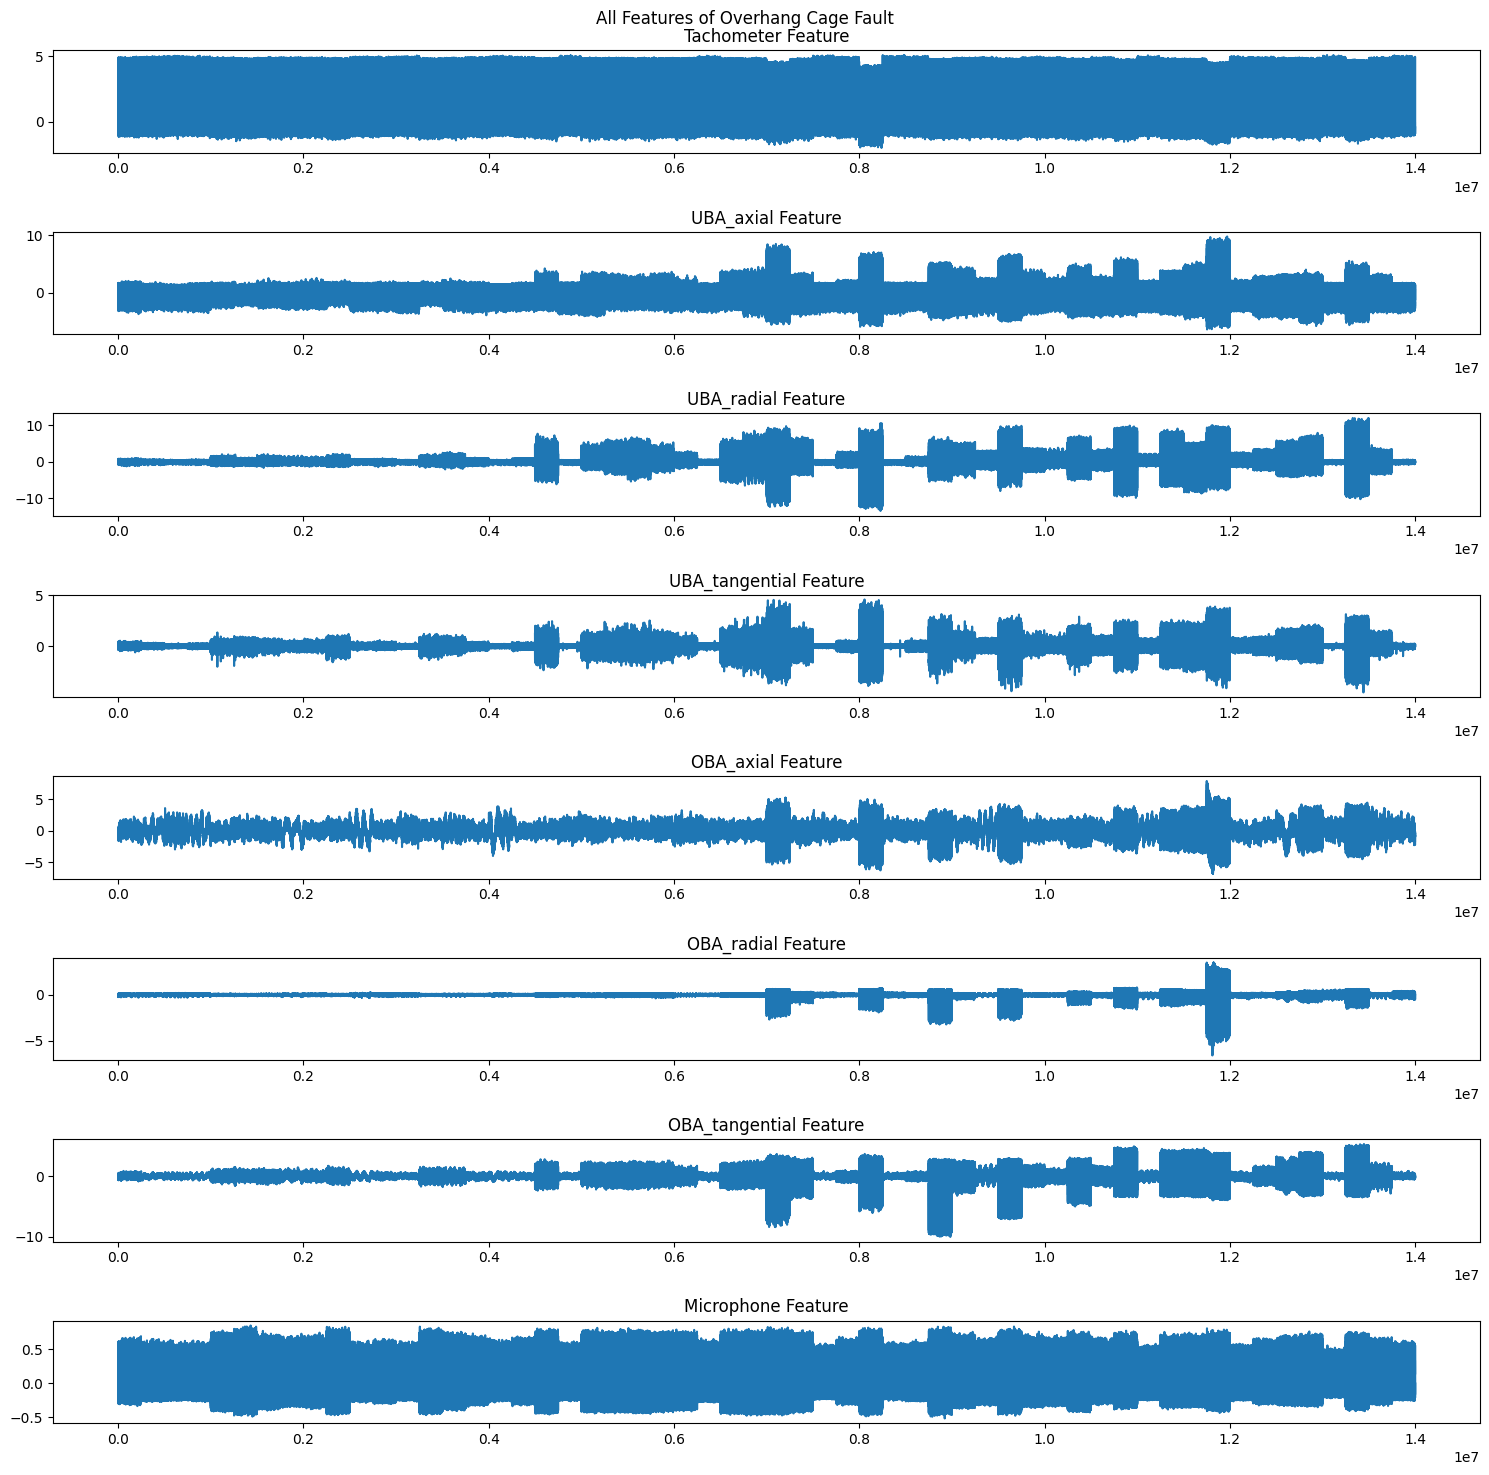

In [7]:
plot_data(overhang_cage_train,"Overhang Cage Fault")

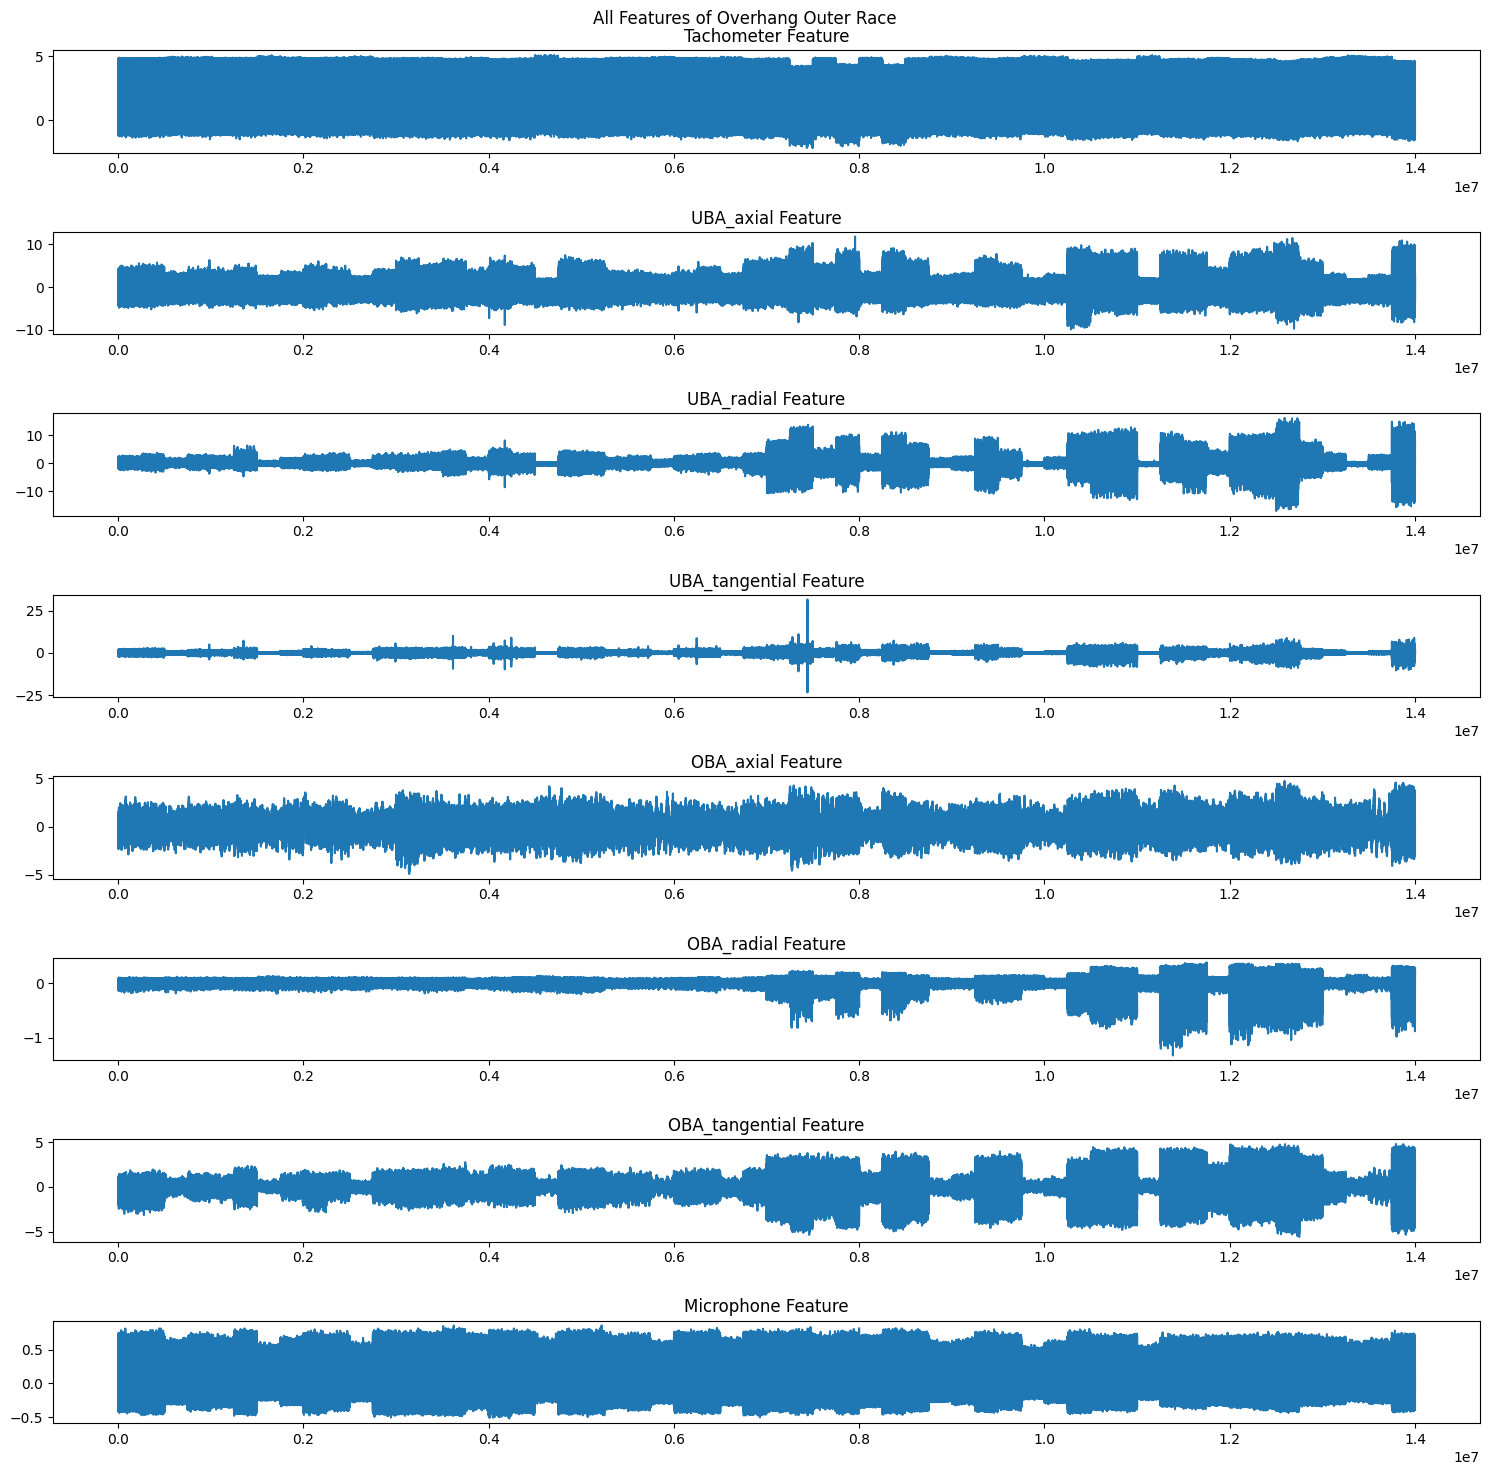

In [6]:
plot_data(overhang_outer_train,"Overhang Outer Race")

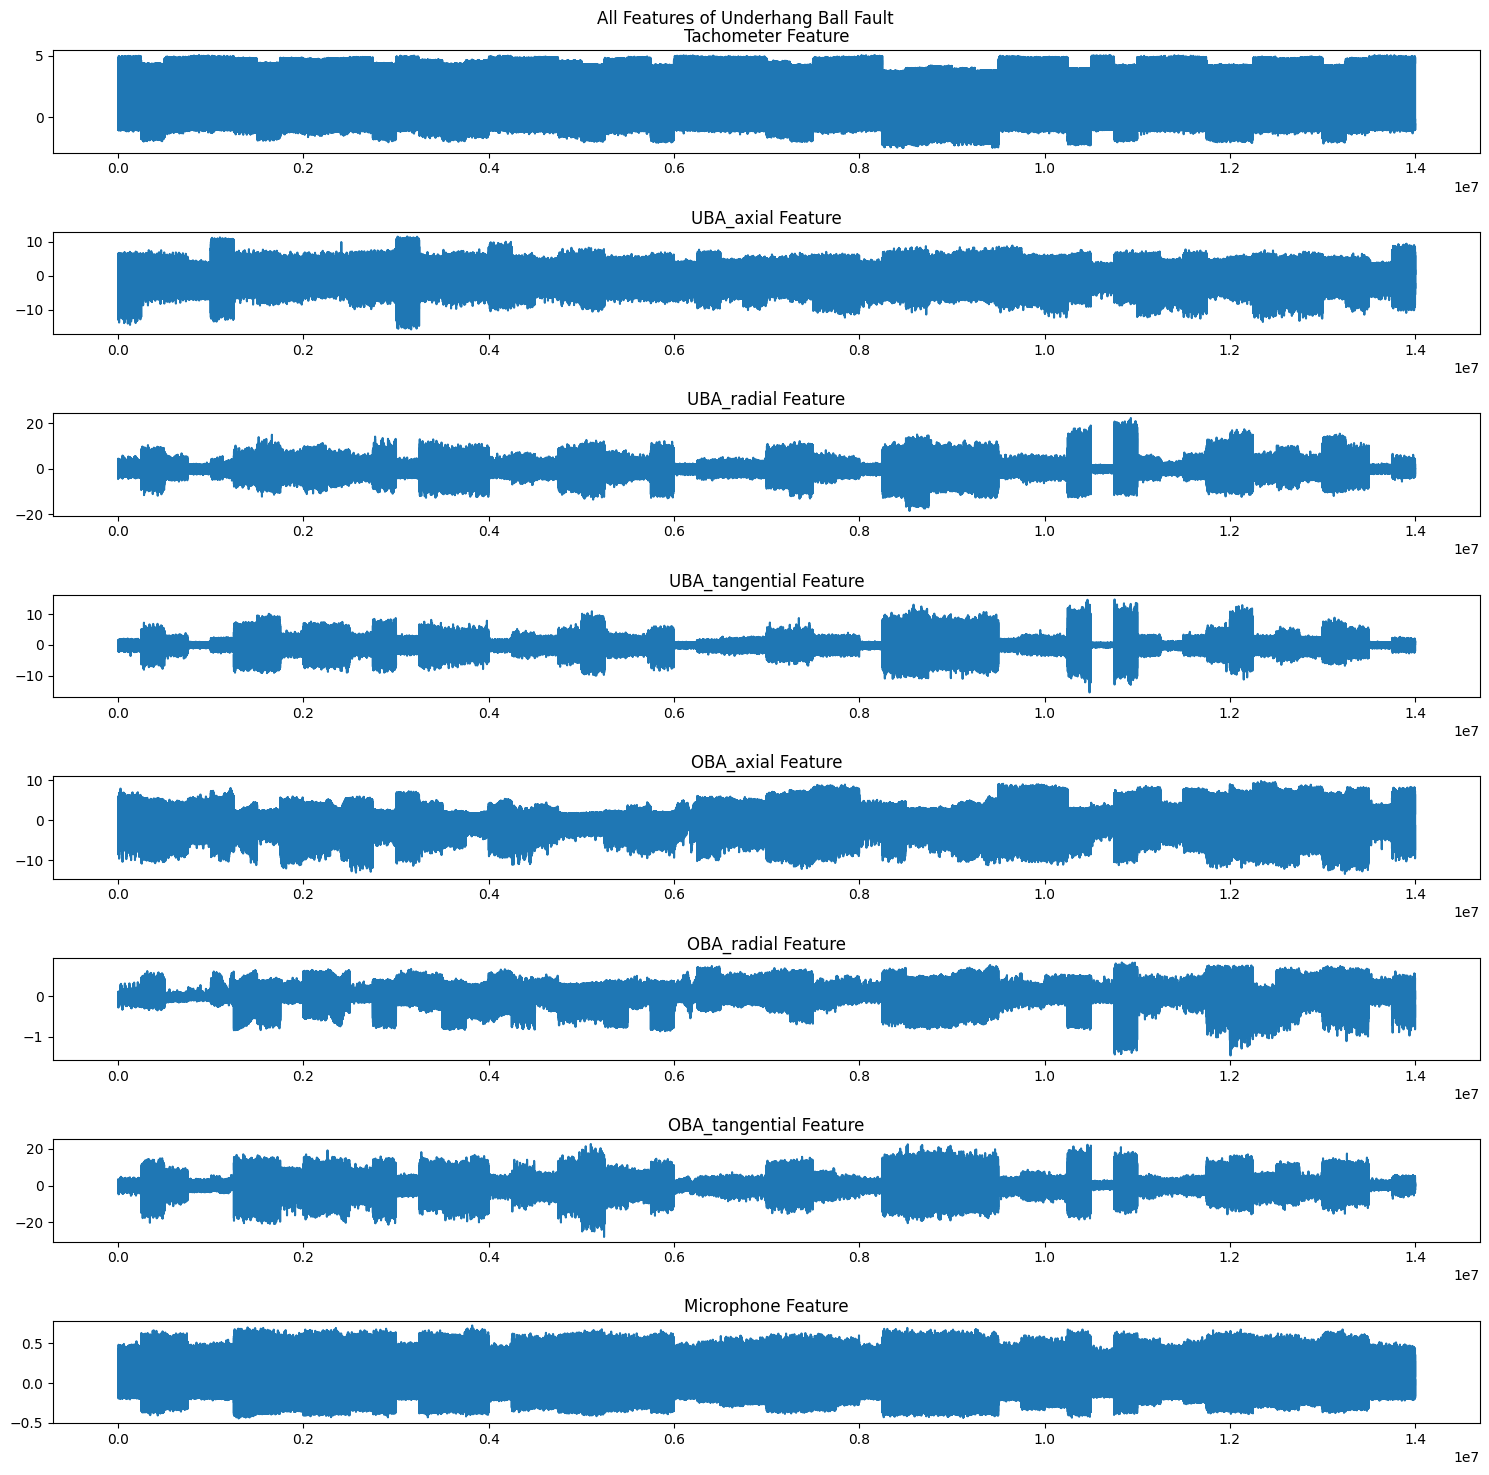

In [6]:
plot_data(underhang_ball_train,"Underhang Ball Fault")

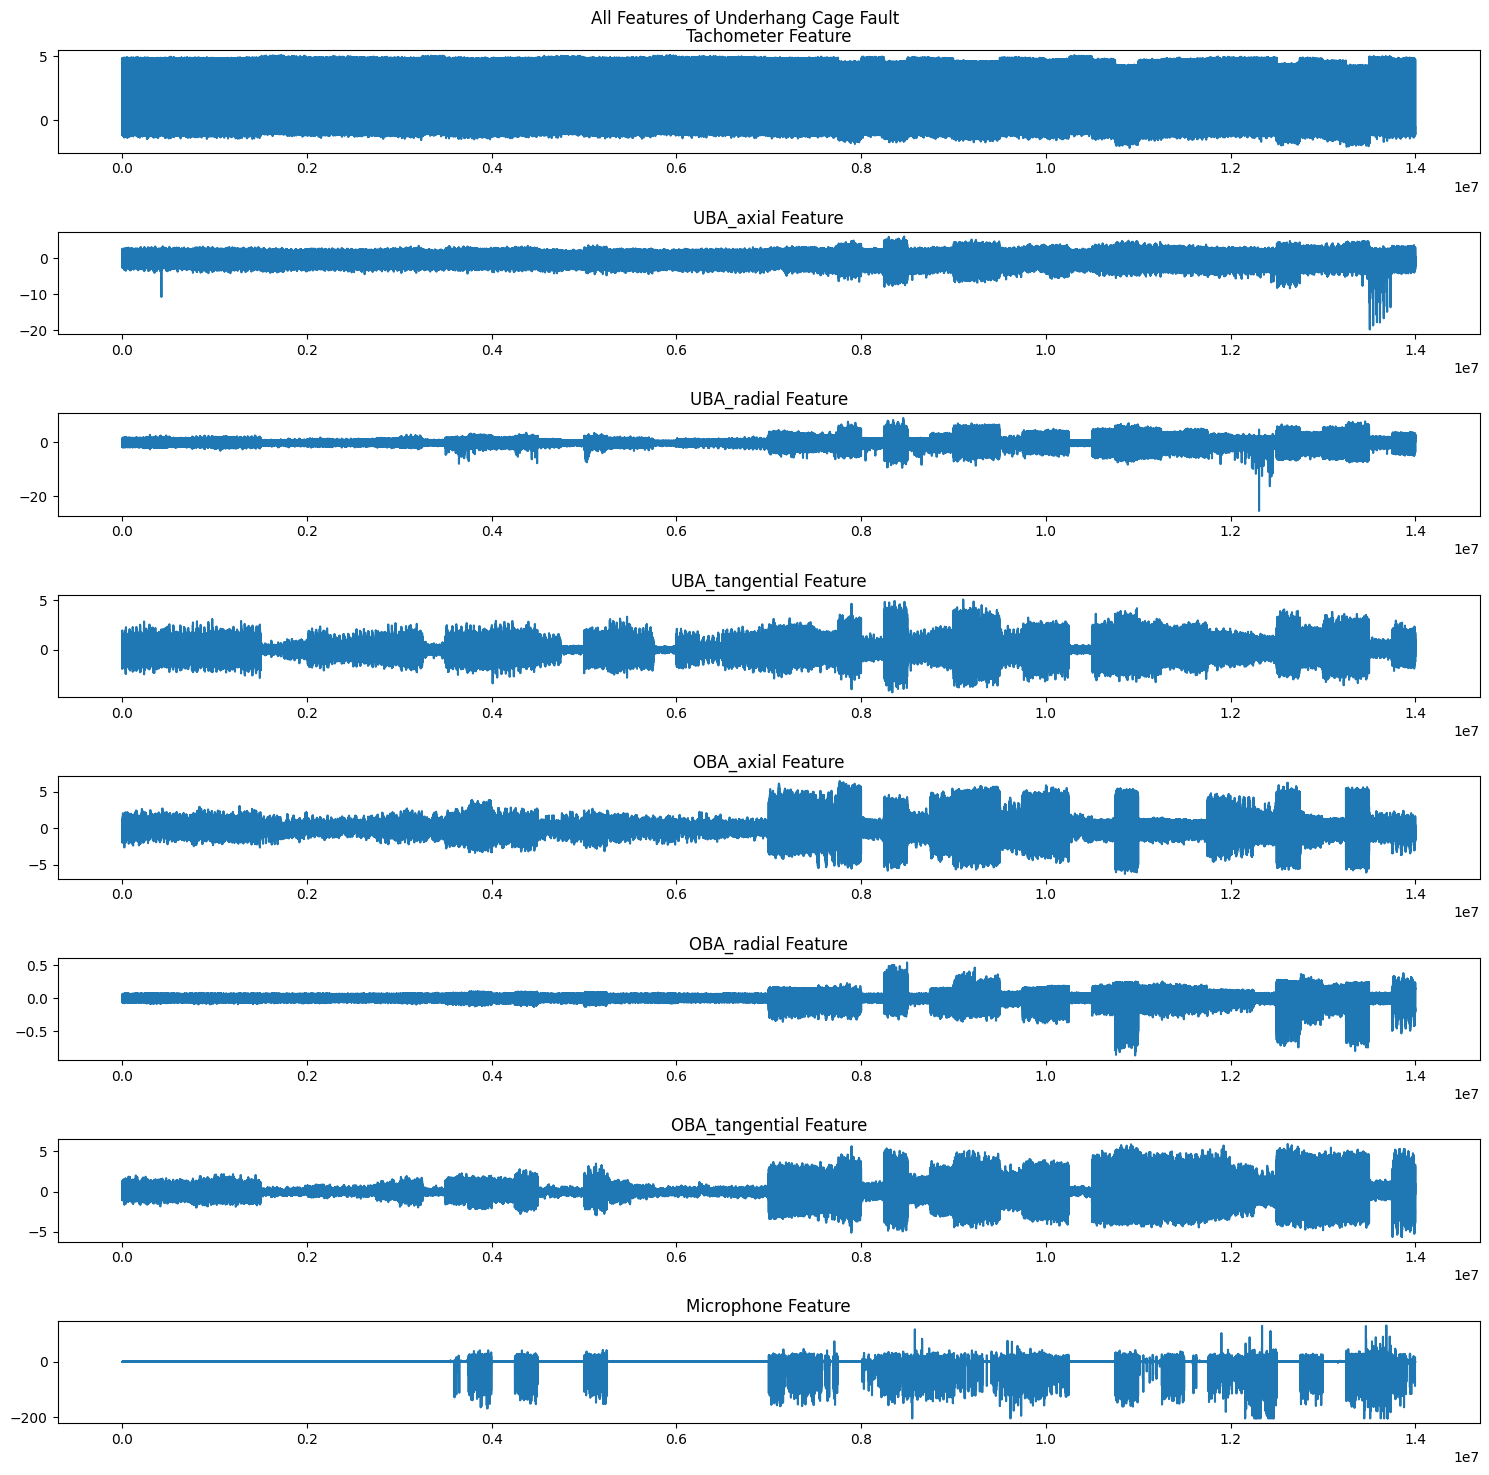

In [5]:
plot_data(underhang_cage_train,"Underhang Cage Fault")

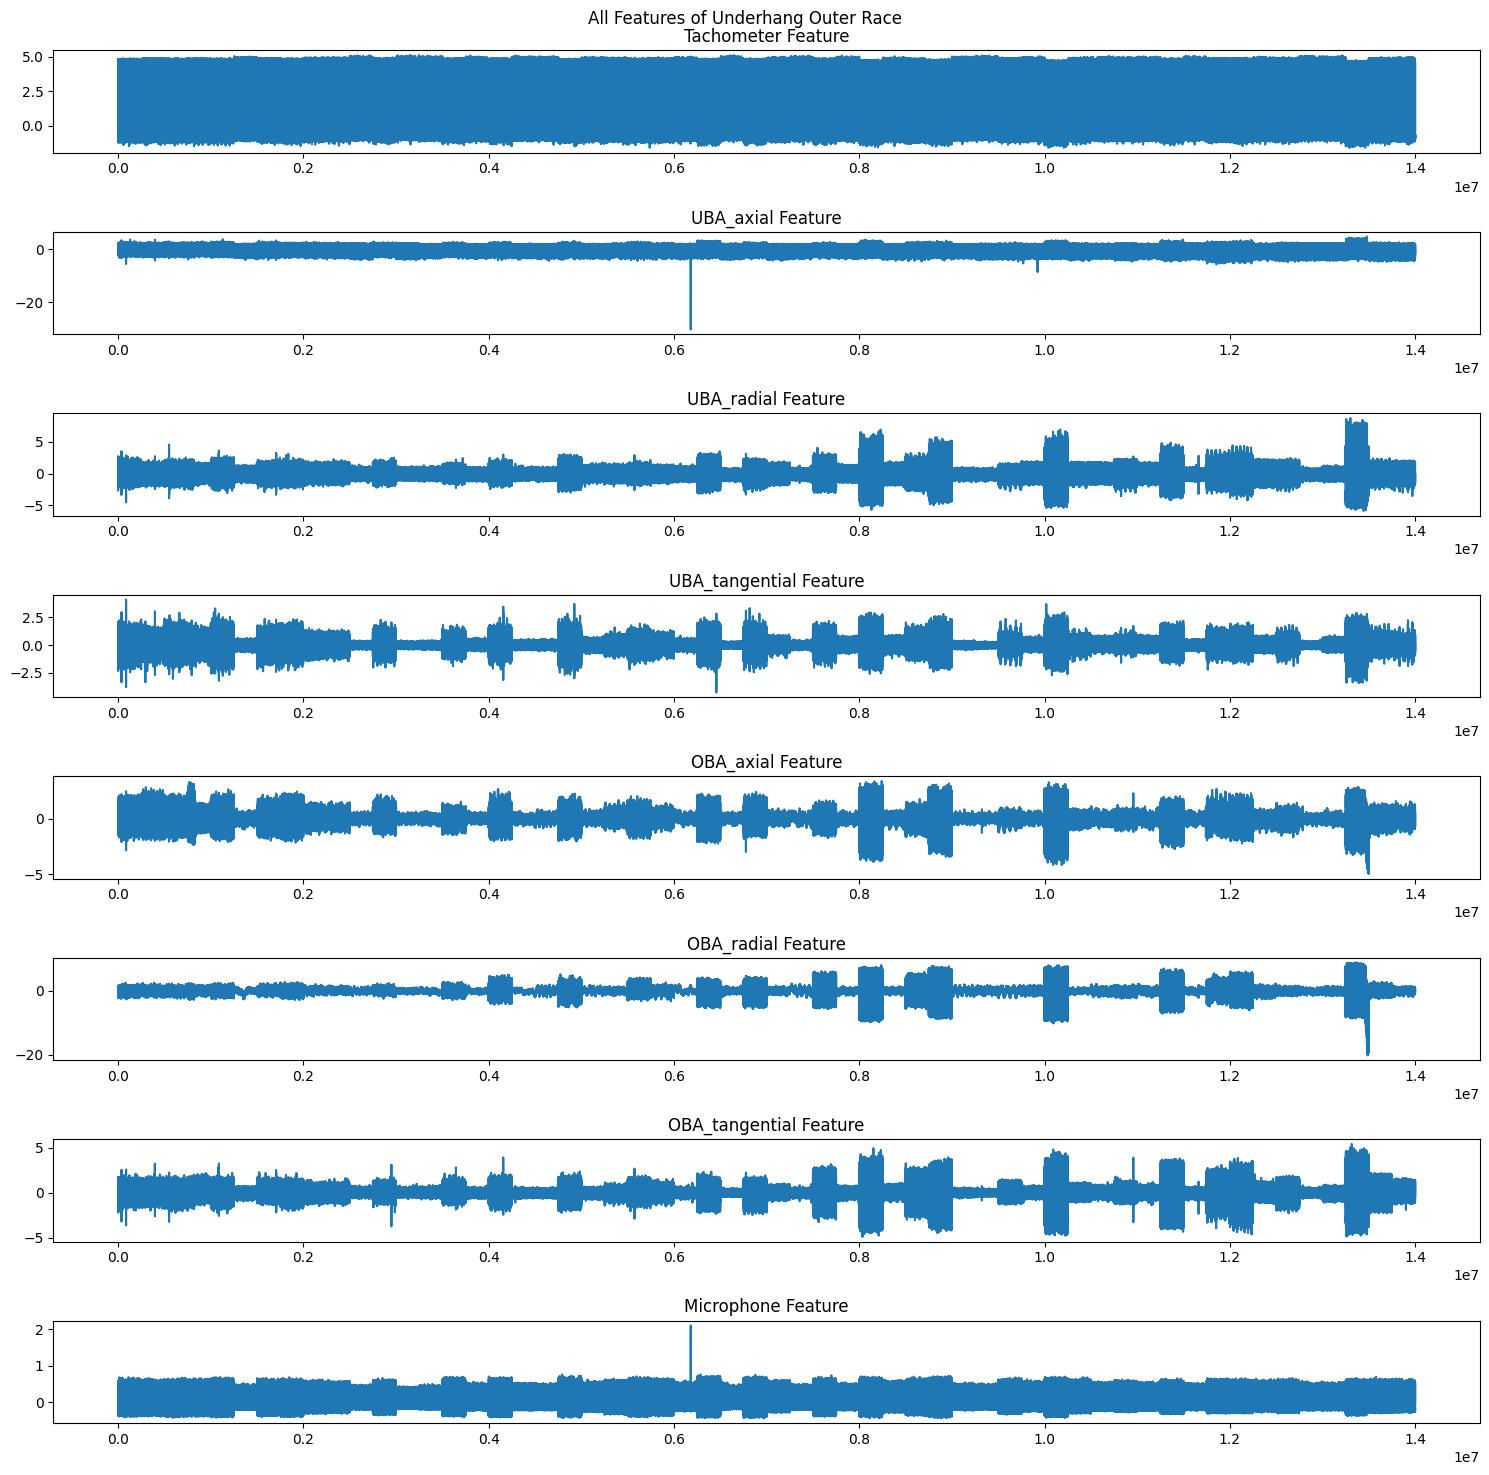

In [5]:
plot_data(underhang_outer_train,"Underhang Outer Race")

In [6]:
# Dictionary for train and test data with class labels
datasets = {
    "normal": {
        "train": normal_train,
        "test": normal_test,
        "label": 0
    },
    "horizontal": {
        "train": horizontal_train,
        "test": horizontal_test,
        "label": 1
    },
    "vertical": {
        "train": vertical_train,
        "test": vertical_test,
        "label": 2
    },
    "imbalance": {
        "train": imbalance_train,
        "test": imbalance_test,
        "label": 3
    },
    "overhang_ball": {
        "train": overhang_ball_train,
        "test": overhang_ball_test,
        "label": 4
    },
    "overhang_cage": {
        "train": overhang_cage_train,
        "test": overhang_cage_test,
        "label": 5
    },
    "overhang_outer": {
        "train": overhang_outer_train,
        "test": overhang_outer_test,
        "label": 6
    },
    "underhang_ball": {
        "train": underhang_ball_train,
        "test": underhang_ball_test,
        "label": 7
    },
    "underhang_cage": {
        "train": underhang_cage_train,
        "test": underhang_cage_test,
        "label": 8
    },
    "underhang_outer": {
        "train": underhang_outer_train,
        "test": underhang_outer_test,
        "label": 9
    }
}


df_train = pd.DataFrame()
df_test = pd.DataFrame()
df = pd.DataFrame()

In [7]:
df = pd.DataFrame()
df_train = pd.DataFrame()
for key in datasets:
    print(key)
    shift = 3750
    if key == "normal":
        shift = 900
    elif key == "imbalance":
        shift = 6500
    elif key == "vertical":
        shift = 5800
    df = feature_extraction_window(datasets[key]["train"], datasets[key]["label"], shift)

df_train = df
df_train['Fault'].value_counts()

normal
horizontal
vertical
imbalance
overhang_ball
overhang_cage
overhang_outer
underhang_ball
underhang_cage
underhang_outer


Fault
0    3751
3    3751
1    3701
4    3701
5    3701
6    3701
7    3701
8    3701
9    3701
2    3600
Name: count, dtype: int64

In [8]:
df = pd.DataFrame()
for key in datasets:
    print(key)
    shift = 1875
    if key == "normal":
        shift = 400
    elif key == "imbalance":
        shift = 3325
    elif key == "vertical":
        shift = 2925
    df = feature_extraction_window(datasets[key]["test"], datasets[key]["label"], shift)

df_test = df
df_test['Fault'].value_counts()

normal
horizontal
vertical
imbalance
overhang_ball
overhang_cage
overhang_outer
underhang_ball
underhang_cage
underhang_outer


Fault
0    3438
1    3134
4    3134
5    3134
6    3134
7    3134
8    3134
9    3134
3    3121
2    3035
Name: count, dtype: int64

In [9]:
df_train.sample(10)

Tachometer_Mean  Tachometer_Variance  Tachometer_Skewness  \
3876          0.002636             3.053740             2.101218   
6764         -0.001174             3.202037             2.015325   
36901        -0.013851             3.111833             2.062470   
15468        -0.000297             2.536629             2.453345   
4616         -0.002316             2.944733             2.182611   
17427         0.001583             3.138571             2.050671   
7838         -0.000822             2.957572             2.175077   
19440         0.001735             3.141799             2.050803   
21990        -0.013532             2.514602             2.496547   
30451        -0.001079             2.976821             2.150098   

       Tachometer_Kurtosis  Tachometer_Dominant_Frequency  UBA_axial_Mean  \
3876              2.463450                       0.003906        0.017159   
6764              2.094310                       0.003906        0.008361   
36901             2.303809                       0.003906        0.138376   
15468             4.076310                       0.003906        0.015224   
4616              2.800501                       0.003906        0.010172   
17427             2.236792                       0.003906        0.017021   
7838              2.766946                       0.003906        0.012860   
19440             2.238724                       0.003906        0.019998   
21990             4.283507                       0.003906        0.030605   
30451             2.673299                       0.003906        0.008878   

       UBA_axial_Variance  UBA_axial_Skewness  UBA_axial_Kurtosis  \
3876             0.495863           -0.395117            0.708087   
6764             0.640600           -0.183678            0.409278   
36901            1.147959           -0.389289            0.067580   
15468           18.936643           -1.360588            1.216856   
4616             0.548147           -0.510838           -0.369667   
17427           27.782047           -1.080485            2.519038   
7838             0.787097           -0.388417           -0.495541   
19440            0.573366           -0.415717            0.019573   
21990            1.134023           -0.362611           -0.938388   
30451            0.705717           -0.259884           -0.184704   

       UBA_axial_Dominant_Frequency  ...  OBA_tangential_Variance  \
3876                       0.441406  ...                 0.138087   
6764                       0.007812  ...                 0.801816   
36901                      0.441406  ...                 1.610313   
15468                      0.003906  ...                 0.220526   
4616                       0.441406  ...                 0.080396   
17427                      0.007812  ...                 2.624305   
7838                       0.441406  ...                 0.176653   
19440                      0.441406  ...                 0.199852   
21990                      0.441406  ...                 0.050598   
30451                      0.441406  ...                 0.138256   

       OBA_tangential_Skewness  OBA_tangential_Kurtosis  \
3876                 -0.009302                 0.404192   
6764                 -0.081184                -0.274540   
36901                -0.086106                -0.541038   
15468                -0.099557                 5.646660   
4616                 -0.126497                 0.194616   
17427                 0.061147                -0.716987   
7838                  0.013821                -0.312580   
19440                -0.120821                -0.307063   
21990                 0.065100                -0.529449   
30451                -0.119673                 0.927555   

       OBA_tangential_Dominant_Frequency  Microphone_Mean  \
3876                            0.003906         0.016305   
6764                            0.003906         0.011117   
36901                           0.003906         0.014172

In [10]:
df_train.shape

(37009, 41)

In [11]:
df_train.describe()

Tachometer_Mean  Tachometer_Variance  Tachometer_Skewness  \
count     37009.000000         37009.000000         37009.000000   
mean          0.000108             3.121041             2.077277   
std           0.004545             0.471058             0.276867   
min          -0.027888             2.456689             0.584857   
25%          -0.002509             2.881753             2.024490   
50%           0.000174             3.041831             2.116920   
75%           0.002700             3.178044             2.223241   
max           0.023314             5.927711             2.527590   

       Tachometer_Kurtosis  Tachometer_Dominant_Frequency  UBA_axial_Mean  \
count         37009.000000                   37009.000000    37009.000000   
mean              2.432633                       0.003916        0.010931   
std               0.993856                       0.000195        0.008821   
min              -1.647606                       0.003906       -0.051320   
25%               2.134804                       0.003906        0.006508   
50%               2.517554                       0.003906        0.010372   
75%               2.983637                       0.003906        0.014006   
max               4.441828                       0.007812        0.142036   

       UBA_axial_Variance  UBA_axial_Skewness  UBA_axial_Kurtosis  \
count        37009.000000        37009.000000        37009.000000   
mean             4.877750           -0.347832            0.101235   
std             13.984235            0.363812            1.351310   
min              0.226369           -1.693680           -1.059018   
25%              0.641179           -0.443502           -0.427299   
50%              0.958088           -0.359349           -0.089406   
75%              2.146411           -0.200636            0.245653   
max            196.291062            0.980078           33.420650   

       UBA_axial_Dominant_Frequency  ...  OBA_tangential_Variance  \
count                  37009.000000  ...             37009.000000   
mean                       0.211418  ...                 1.640978   
std                        0.217358  ...                 3.152336   
min                        0.003906  ...                 0.010779   
25%                        0.003906  ...                 0.164762   
50%                        0.007812  ...                 0.404418   
75%                        0.441406  ...                 1.852359   
max                        0.441406  ...                25.568170   

       OBA_tangential_Skewness  OBA_tangential_Kurtosis  \
count             37009.000000             37009.000000   
mean                 -0.025074                 0.100766   
std                   0.298165                 1.866291   
min                  -6.950857                -1.505480   
25%                  -0.125753                -0.483563   
50%                   0.003881                -0.113668   
75%                   0.120129                 0.226441   
max                   2.287340               123.974631   

       OBA_tangential_Dominant_Frequency  Microphone_Mean  \
count                       37009.000000     37009.000000   
mean                            0.011533         0.011932   
std                             0.017749         0.005498   
min                             0.003906        -0.033573   
25%                             0.003906         0.012071   
50%                             0.003906         0.012903   
75%                             0.003906         0.013791   
max                             0.070312         0.033089   

       Microphone_Variance  Microphone_Skewness  Microphone_Kurtosis  \
count         37009.000000         37009.000000         37009.000000   
mean              0.246651            -5.531578           662.614403   
std               0.864195            21.596836          3438.881805   
min               0.007365          -268.698007            -1.127387   
25%           

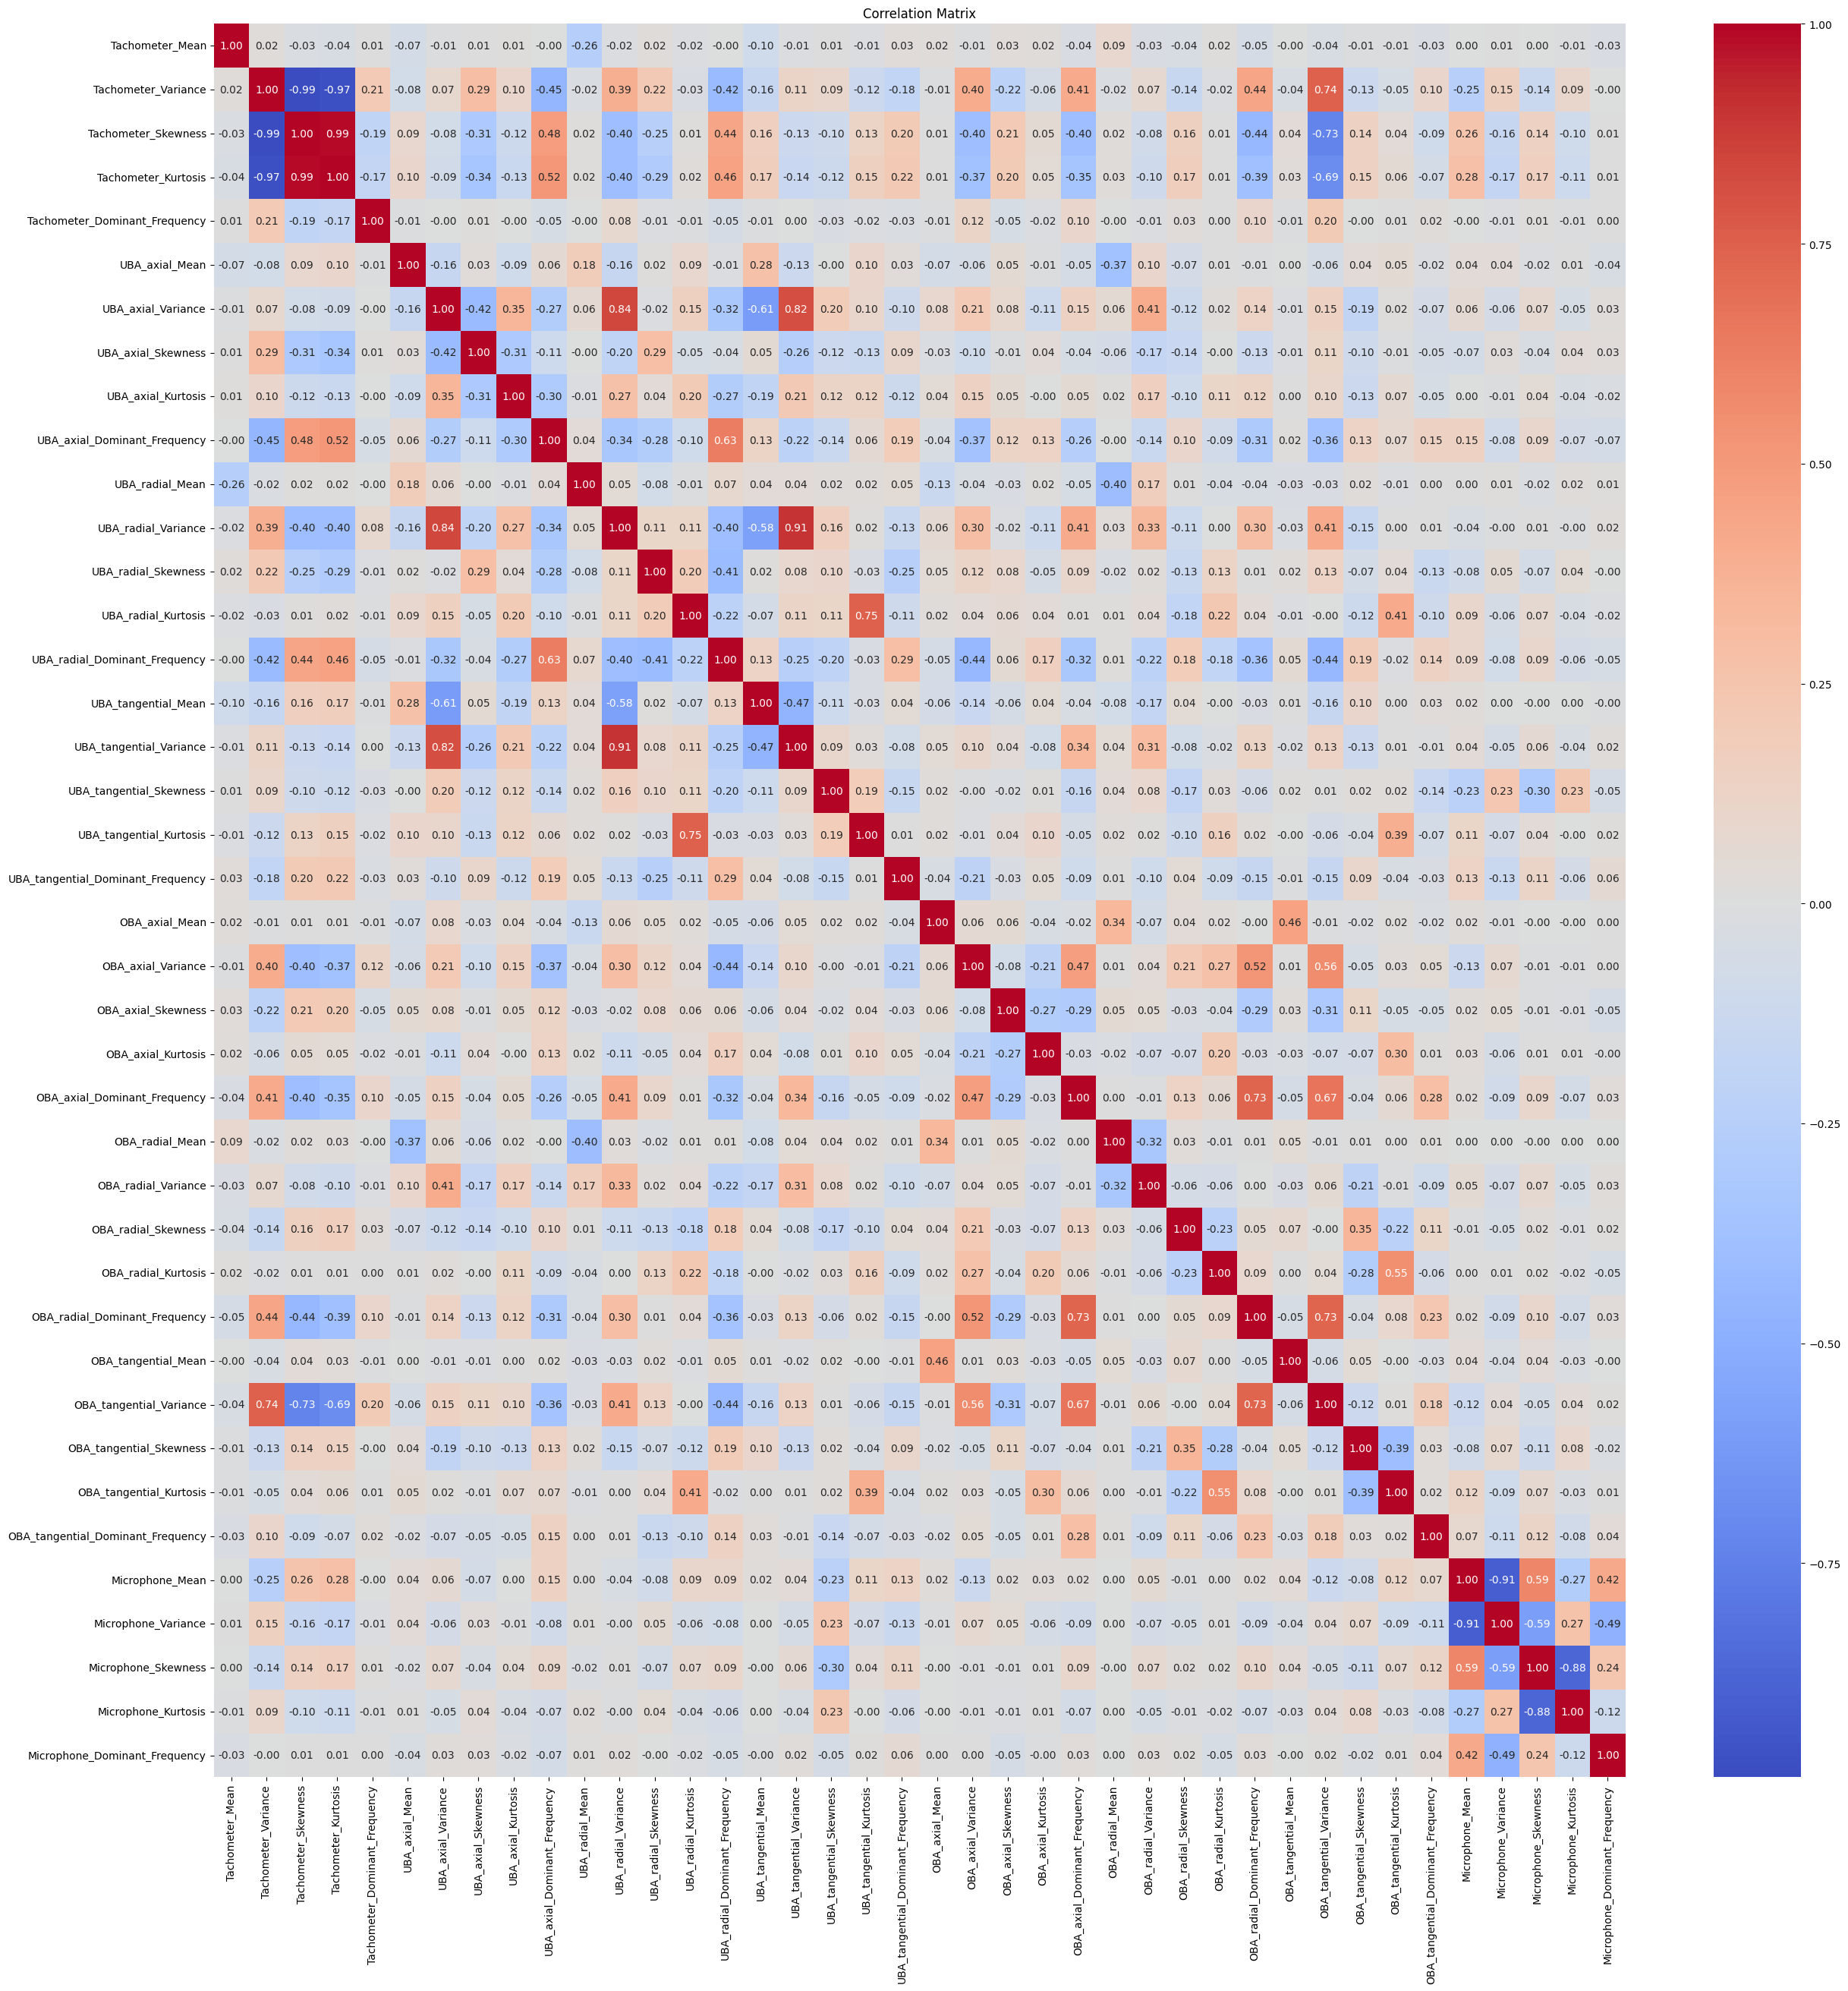

In [12]:
correlation_matrix = df_train.drop('Fault', axis=1).corr()
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

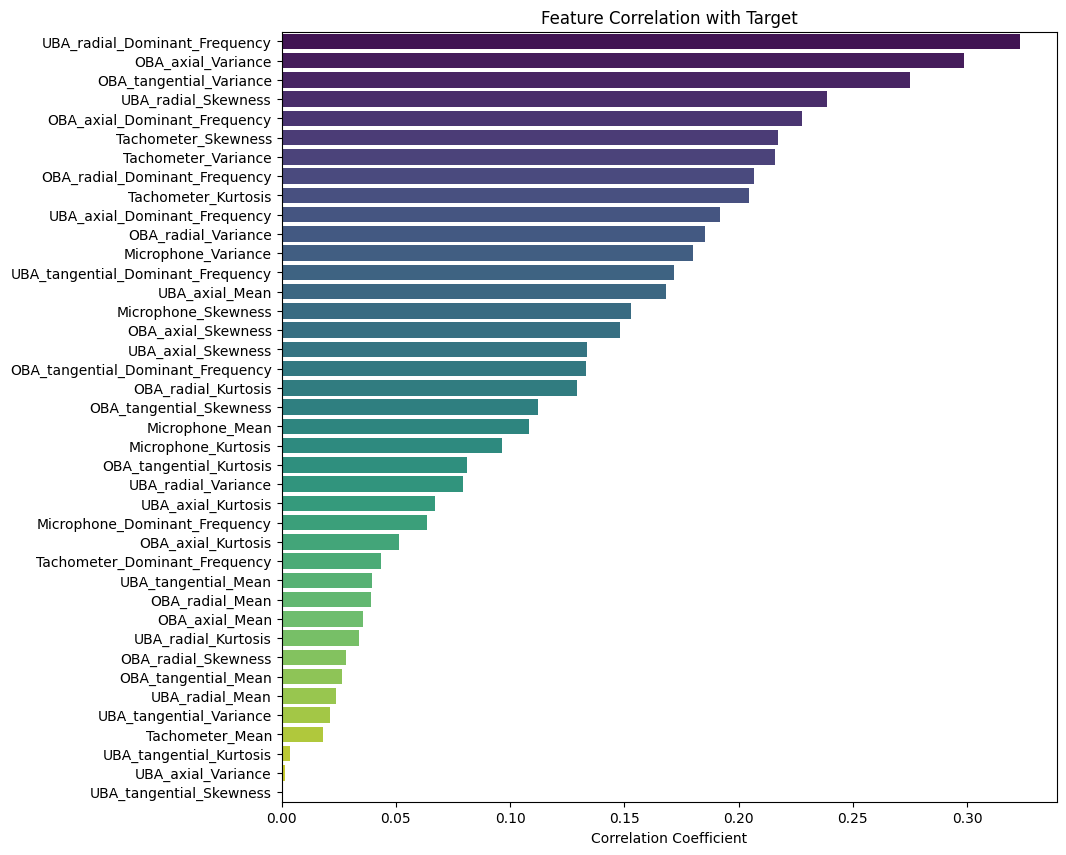

In [13]:
correlation_matrix = df_train.corr()

target_corr = correlation_matrix['Fault'].drop('Fault')

target_corr_sorted = target_corr.abs().sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x=target_corr_sorted.values, y=target_corr_sorted.index, palette="viridis")
plt.title("Feature Correlation with Target")
plt.xlabel("Correlation Coefficient")
plt.show()

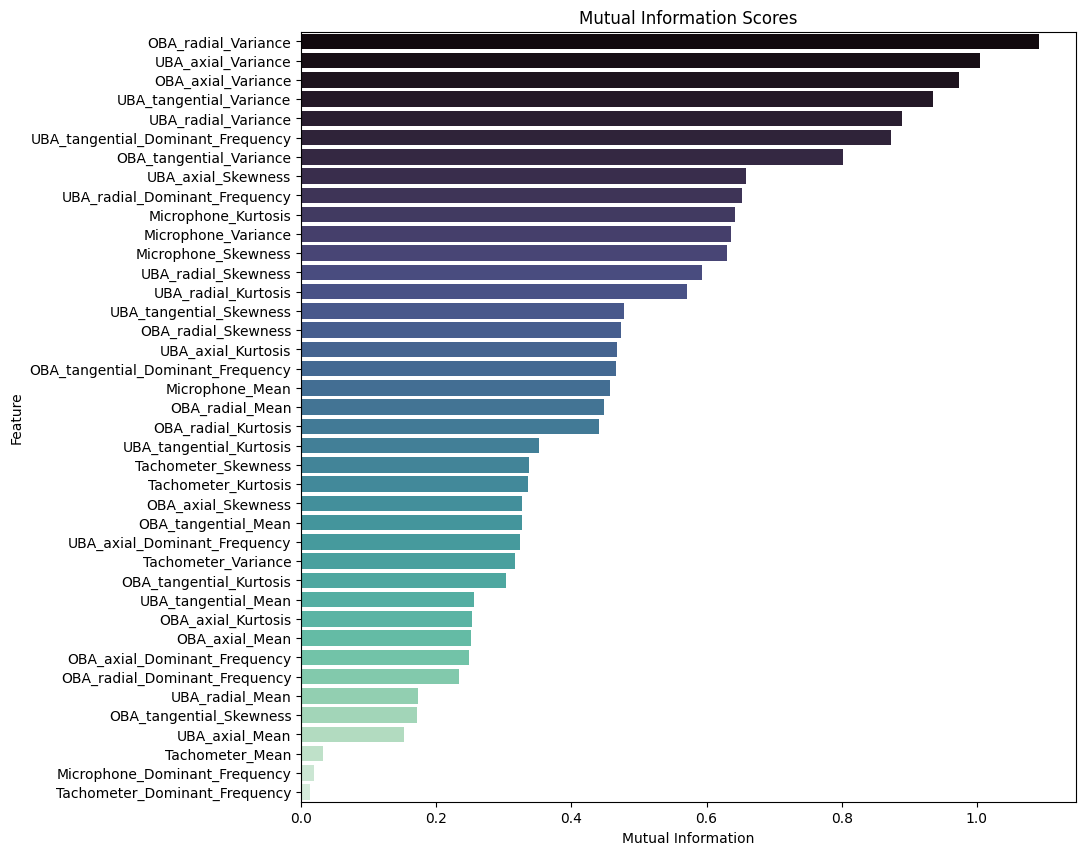

In [14]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(df_train.drop(['Fault'],axis=1), df_train['Fault'])

mi_df = pd.DataFrame({'Feature': df_train.drop(['Fault'],axis=1).columns, 'Mutual Information': mi_scores})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x='Mutual Information', y='Feature', data=mi_df, palette='mako')
plt.title("Mutual Information Scores")
plt.show()


In [15]:
x_train = df_train.drop(['Fault'],axis=1)
y_train = df_train['Fault']
x_test = df_test.drop(['Fault'],axis=1)
y_test = df_test['Fault']

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Model: Logistic Regression (Training Data)
Training Accuracy: 0.96
Training Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      3751
           1       0.90      0.92      0.91      3701
           2       0.97      0.94      0.95      3600
           3       0.94      0.94      0.94      3751
           4       1.00      1.00      1.00      3701
           5       0.96      0.95      0.96      3701
           6       0.96      0.95      0.96      3701
           7       1.00      1.00      1.00      3701
           8       0.96      0.95      0.95      3701
           9       0.98      0.98      0.98      3701

    accuracy                           0.96     37009
   macro avg       0.96      0.96      0.96     37009
weighted avg       0.96      0.96      0.96     37009



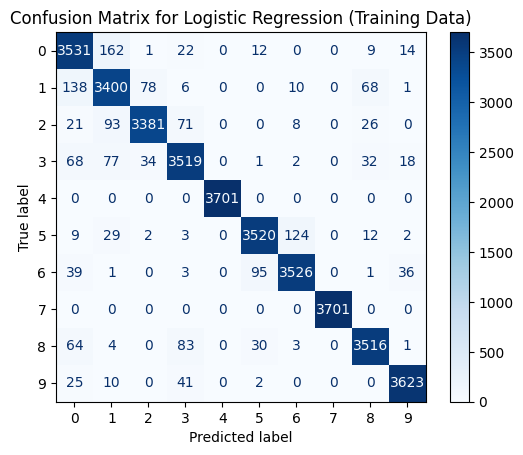


Model: Logistic Regression (Test Data)
Test Accuracy: 0.88
Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.66      0.76      3438
           1       0.83      0.81      0.82      3134
           2       0.90      0.92      0.91      3035
           3       0.85      0.89      0.87      3121
           4       1.00      0.97      0.99      3134
           5       0.84      0.89      0.86      3134
           6       0.83      0.86      0.84      3134
           7       0.95      0.97      0.96      3134
           8       0.79      0.82      0.81      3134
           9       0.90      1.00      0.95      3134

    accuracy                           0.88     31532
   macro avg       0.88      0.88      0.88     31532
weighted avg       0.88      0.88      0.88     31532



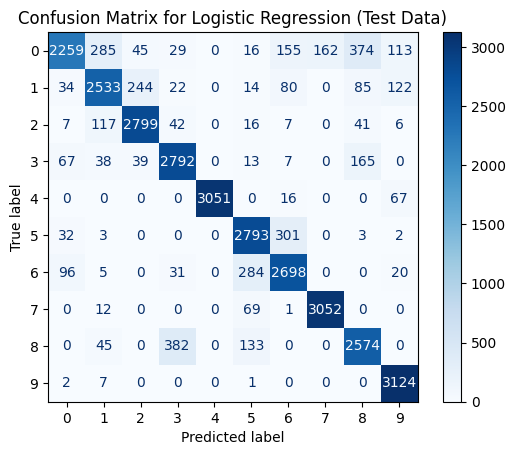

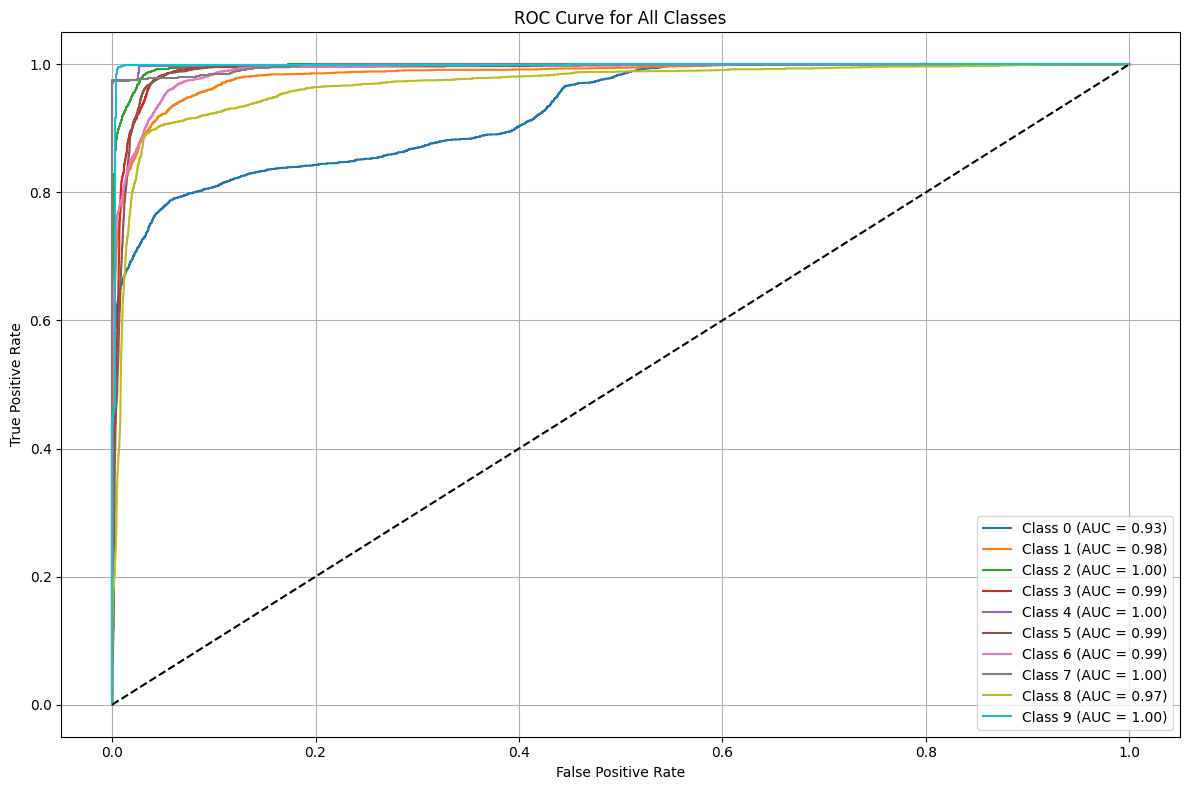


Model: Random Forest (Training Data)
Training Accuracy: 1.00
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3751
           1       1.00      1.00      1.00      3701
           2       1.00      1.00      1.00      3600
           3       1.00      1.00      1.00      3751
           4       1.00      1.00      1.00      3701
           5       1.00      1.00      1.00      3701
           6       1.00      1.00      1.00      3701
           7       1.00      1.00      1.00      3701
           8       1.00      1.00      1.00      3701
           9       1.00      1.00      1.00      3701

    accuracy                           1.00     37009
   macro avg       1.00      1.00      1.00     37009
weighted avg       1.00      1.00      1.00     37009



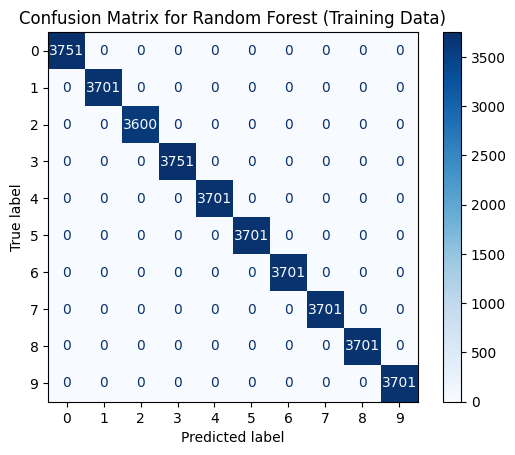


Model: Random Forest (Test Data)
Test Accuracy: 0.95
Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.68      0.81      3438
           1       0.88      0.93      0.91      3134
           2       0.93      0.99      0.96      3035
           3       0.98      1.00      0.99      3121
           4       1.00      1.00      1.00      3134
           5       0.89      1.00      0.94      3134
           6       0.97      0.95      0.96      3134
           7       1.00      1.00      1.00      3134
           8       0.87      0.96      0.91      3134
           9       1.00      1.00      1.00      3134

    accuracy                           0.95     31532
   macro avg       0.95      0.95      0.95     31532
weighted avg       0.95      0.95      0.95     31532



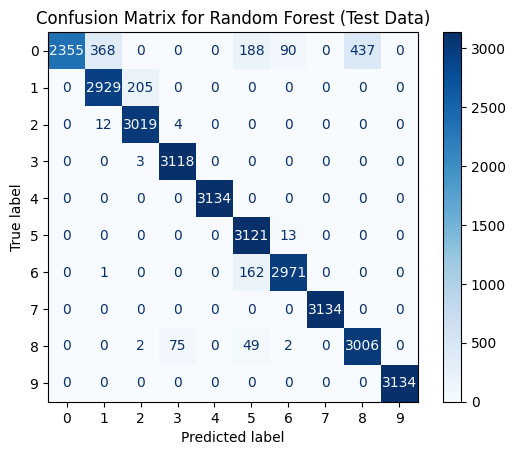

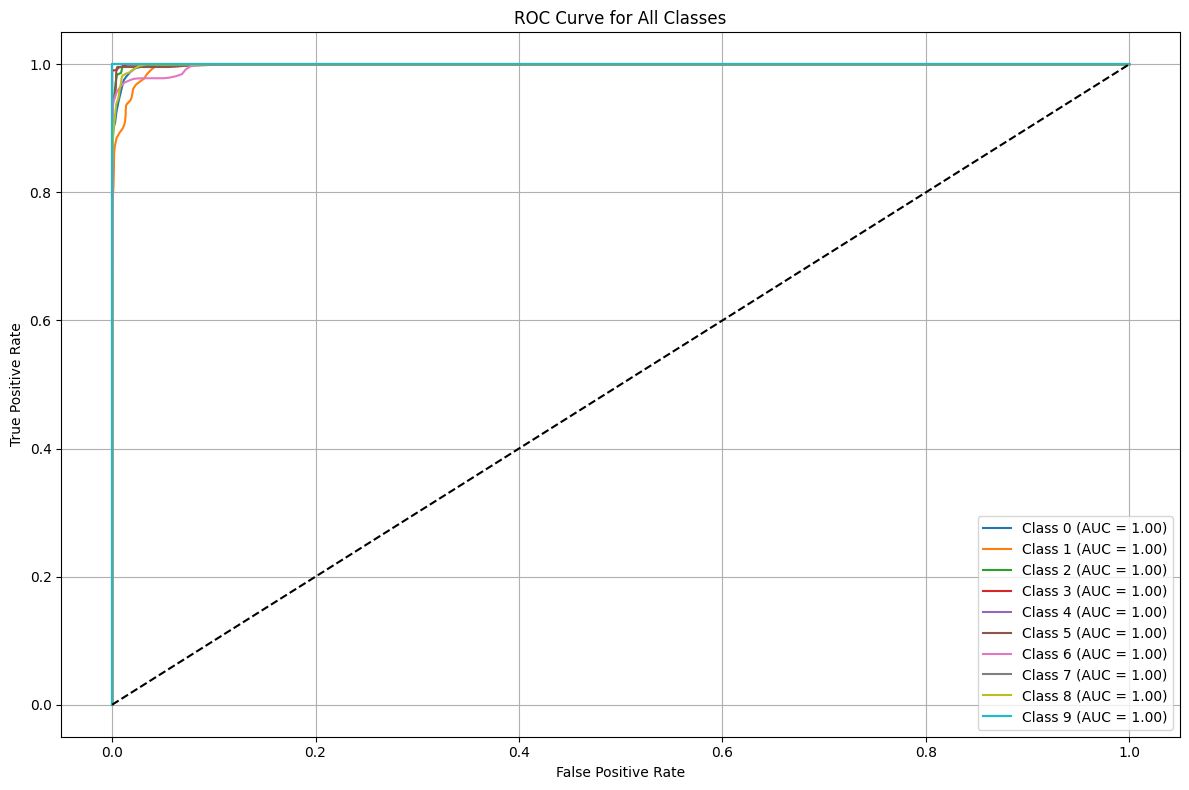


Model: Support Vector Classifier (Training Data)
Training Accuracy: 0.99
Training Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3751
           1       0.98      0.98      0.98      3701
           2       0.99      0.98      0.98      3600
           3       0.99      1.00      0.99      3751
           4       1.00      1.00      1.00      3701
           5       0.99      0.99      0.99      3701
           6       1.00      0.99      1.00      3701
           7       1.00      1.00      1.00      3701
           8       1.00      1.00      1.00      3701
           9       1.00      0.99      0.99      3701

    accuracy                           0.99     37009
   macro avg       0.99      0.99      0.99     37009
weighted avg       0.99      0.99      0.99     37009



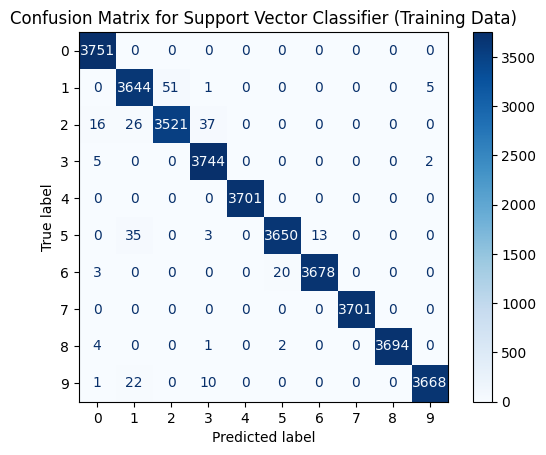


Model: Support Vector Classifier (Test Data)
Test Accuracy: 0.89
Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      3438
           1       0.77      0.84      0.81      3134
           2       0.89      0.95      0.92      3035
           3       0.84      0.98      0.91      3121
           4       1.00      0.98      0.99      3134
           5       0.79      0.91      0.85      3134
           6       0.86      0.80      0.83      3134
           7       1.00      0.98      0.99      3134
           8       0.85      0.74      0.79      3134
           9       0.99      0.96      0.98      3134

    accuracy                           0.89     31532
   macro avg       0.90      0.89      0.89     31532
weighted avg       0.90      0.89      0.89     31532



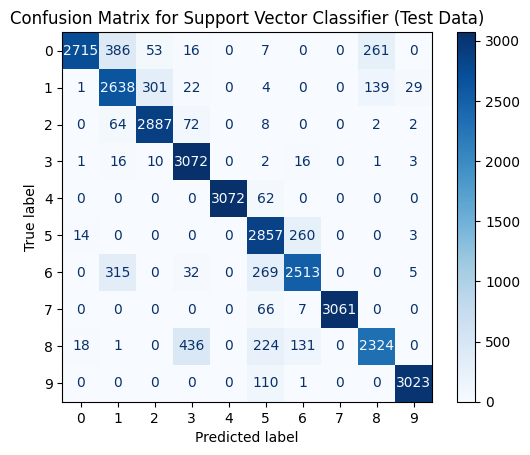


Model: Decision Tree (Training Data)
Training Accuracy: 1.00
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3751
           1       1.00      1.00      1.00      3701
           2       1.00      1.00      1.00      3600
           3       1.00      1.00      1.00      3751
           4       1.00      1.00      1.00      3701
           5       1.00      1.00      1.00      3701
           6       1.00      1.00      1.00      3701
           7       1.00      1.00      1.00      3701
           8       1.00      1.00      1.00      3701
           9       1.00      1.00      1.00      3701

    accuracy                           1.00     37009
   macro avg       1.00      1.00      1.00     37009
weighted avg       1.00      1.00      1.00     37009



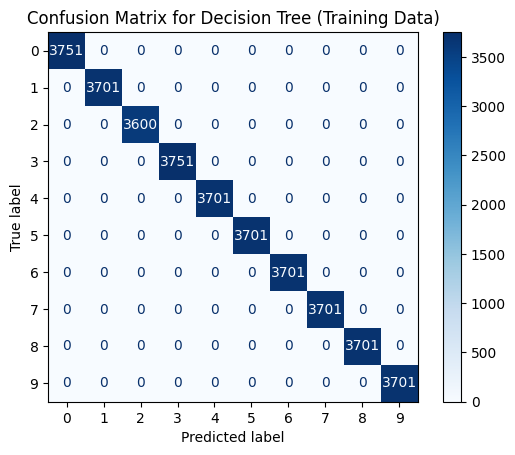


Model: Decision Tree (Test Data)
Test Accuracy: 0.85
Test Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.55      0.68      3438
           1       0.82      0.78      0.80      3134
           2       0.80      0.89      0.84      3035
           3       0.81      0.95      0.88      3121
           4       0.93      1.00      0.96      3134
           5       0.78      0.93      0.85      3134
           6       0.92      0.78      0.84      3134
           7       0.96      0.87      0.91      3134
           8       0.71      0.85      0.77      3134
           9       0.99      0.93      0.96      3134

    accuracy                           0.85     31532
   macro avg       0.86      0.85      0.85     31532
weighted avg       0.86      0.85      0.85     31532



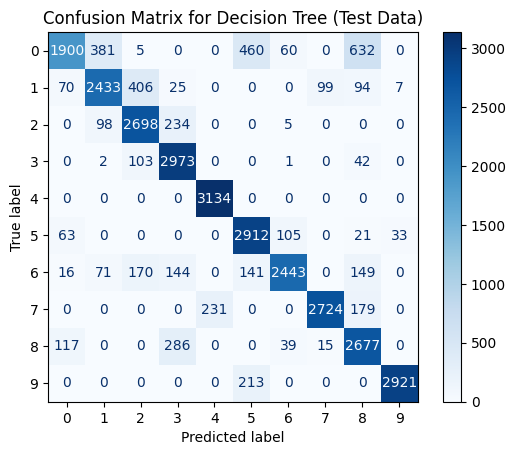

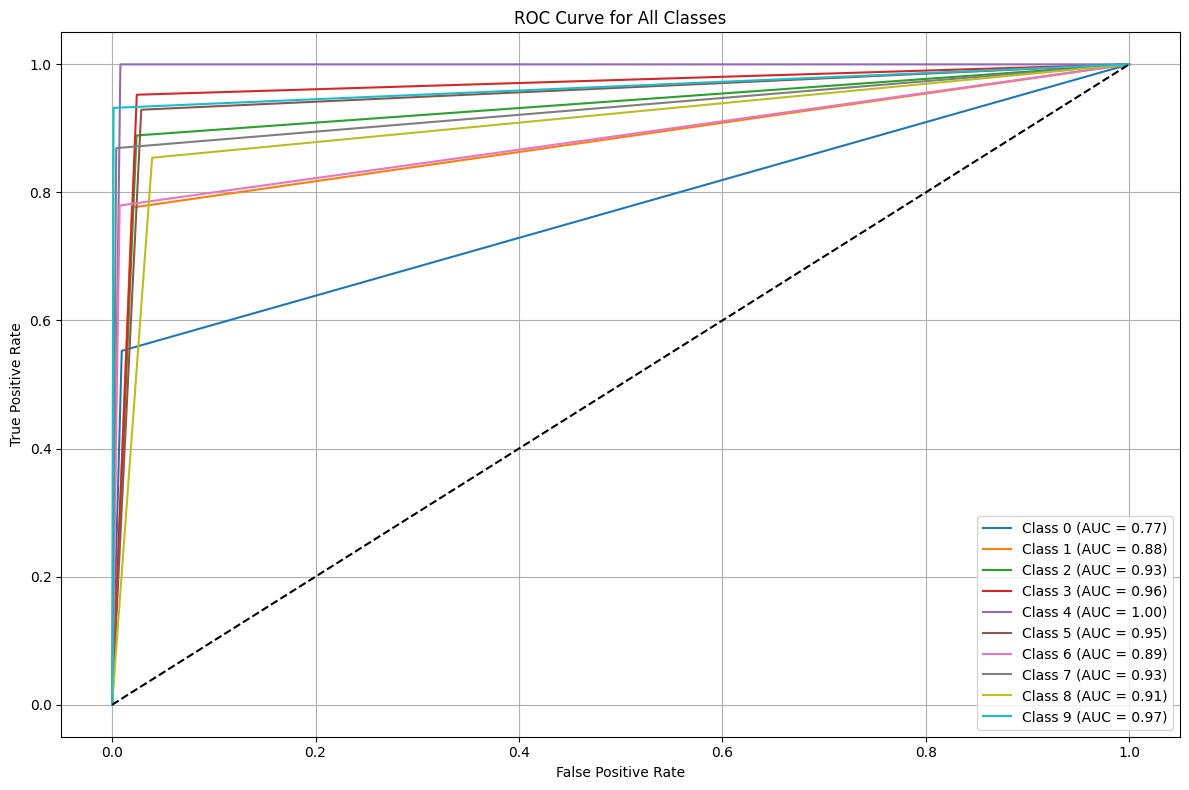


Model: K-Nearest Neighbors (Training Data)
Training Accuracy: 1.00
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3751
           1       0.99      1.00      1.00      3701
           2       0.99      0.99      0.99      3600
           3       1.00      1.00      1.00      3751
           4       1.00      1.00      1.00      3701
           5       1.00      1.00      1.00      3701
           6       1.00      1.00      1.00      3701
           7       1.00      1.00      1.00      3701
           8       1.00      1.00      1.00      3701
           9       1.00      1.00      1.00      3701

    accuracy                           1.00     37009
   macro avg       1.00      1.00      1.00     37009
weighted avg       1.00      1.00      1.00     37009



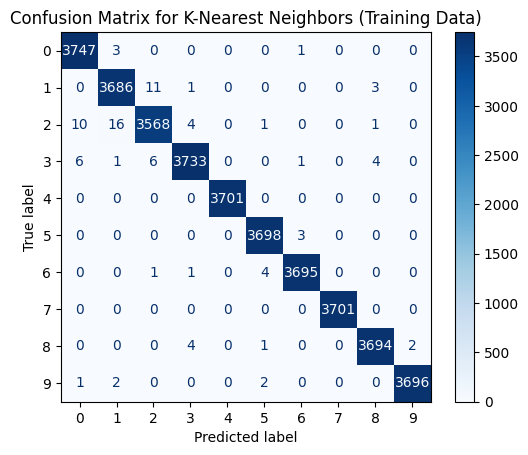


Model: K-Nearest Neighbors (Test Data)
Test Accuracy: 0.85
Test Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      3438
           1       0.67      0.76      0.71      3134
           2       0.80      0.91      0.85      3035
           3       0.82      0.86      0.84      3121
           4       1.00      1.00      1.00      3134
           5       0.80      0.85      0.82      3134
           6       0.79      0.70      0.74      3134
           7       1.00      0.97      0.99      3134
           8       0.79      0.72      0.75      3134
           9       0.96      0.98      0.97      3134

    accuracy                           0.85     31532
   macro avg       0.85      0.85      0.85     31532
weighted avg       0.85      0.85      0.85     31532



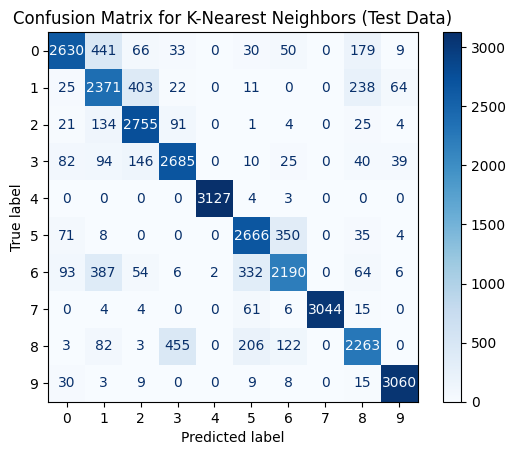

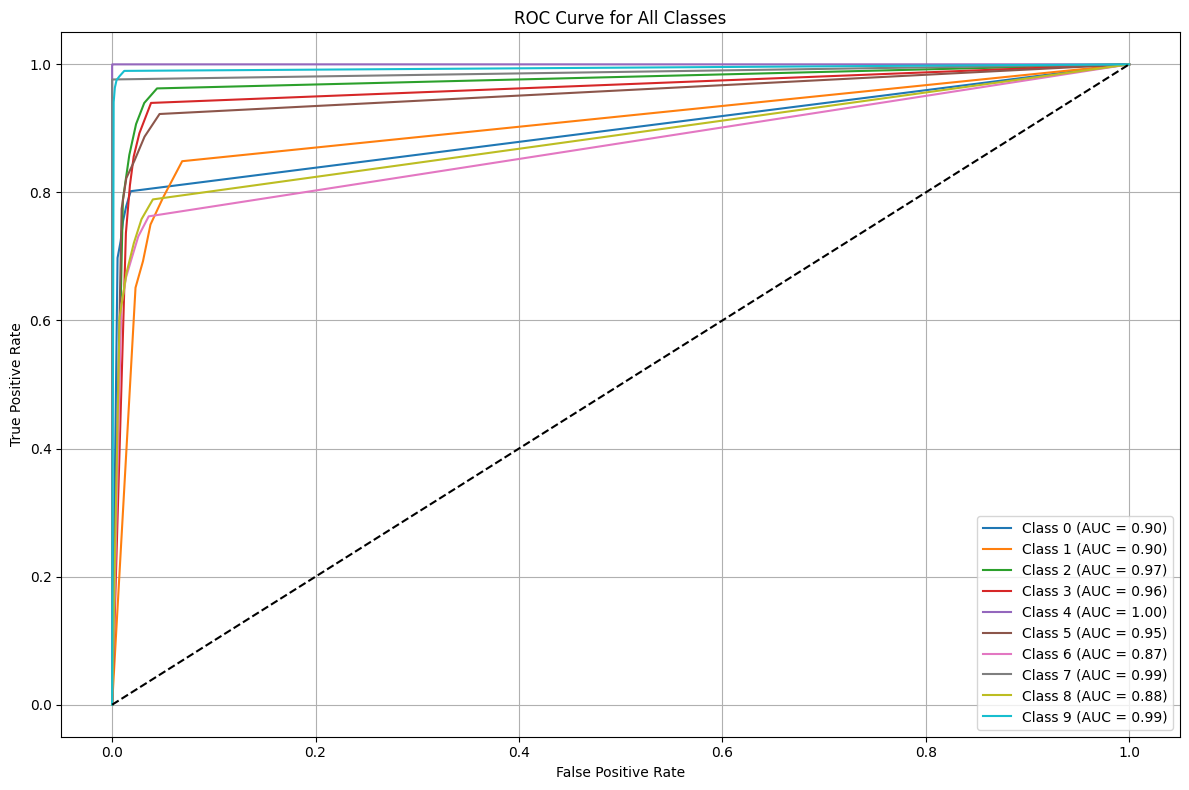


Model: Naive Bayes (Training Data)
Training Accuracy: 0.71
Training Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82      3751
           1       0.42      0.66      0.51      3701
           2       0.71      0.83      0.76      3600
           3       0.99      0.17      0.29      3751
           4       0.98      1.00      0.99      3701
           5       0.56      0.36      0.44      3701
           6       0.54      0.90      0.68      3701
           7       1.00      0.89      0.94      3701
           8       0.70      0.56      0.62      3701
           9       1.00      0.87      0.93      3701

    accuracy                           0.71     37009
   macro avg       0.76      0.71      0.70     37009
weighted avg       0.76      0.71      0.70     37009



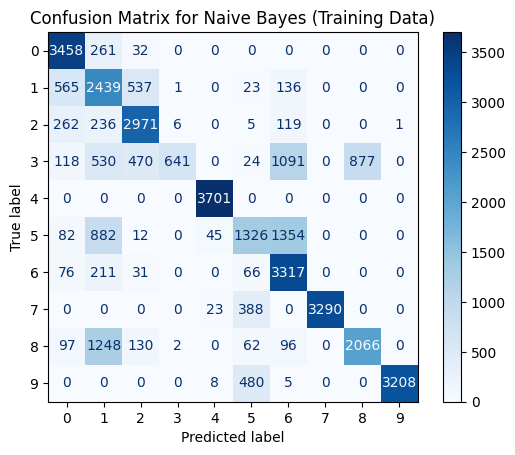


Model: Naive Bayes (Test Data)
Test Accuracy: 0.64
Test Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.63      0.61      3438
           1       0.34      0.56      0.42      3134
           2       0.59      0.72      0.65      3035
           3       0.83      0.14      0.24      3121
           4       0.96      1.00      0.98      3134
           5       0.43      0.29      0.35      3134
           6       0.45      0.69      0.55      3134
           7       1.00      0.88      0.94      3134
           8       0.73      0.61      0.67      3134
           9       0.96      0.90      0.93      3134

    accuracy                           0.64     31532
   macro avg       0.69      0.64      0.63     31532
weighted avg       0.69      0.64      0.63     31532



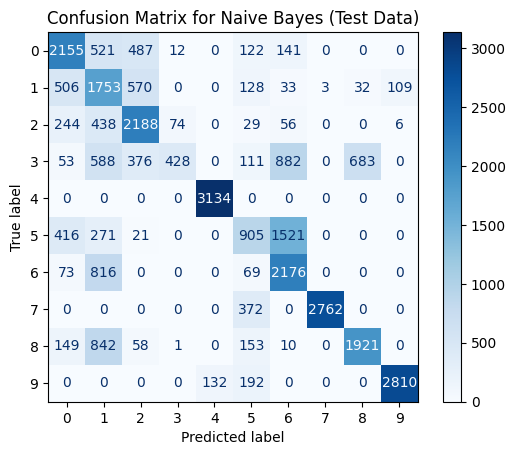

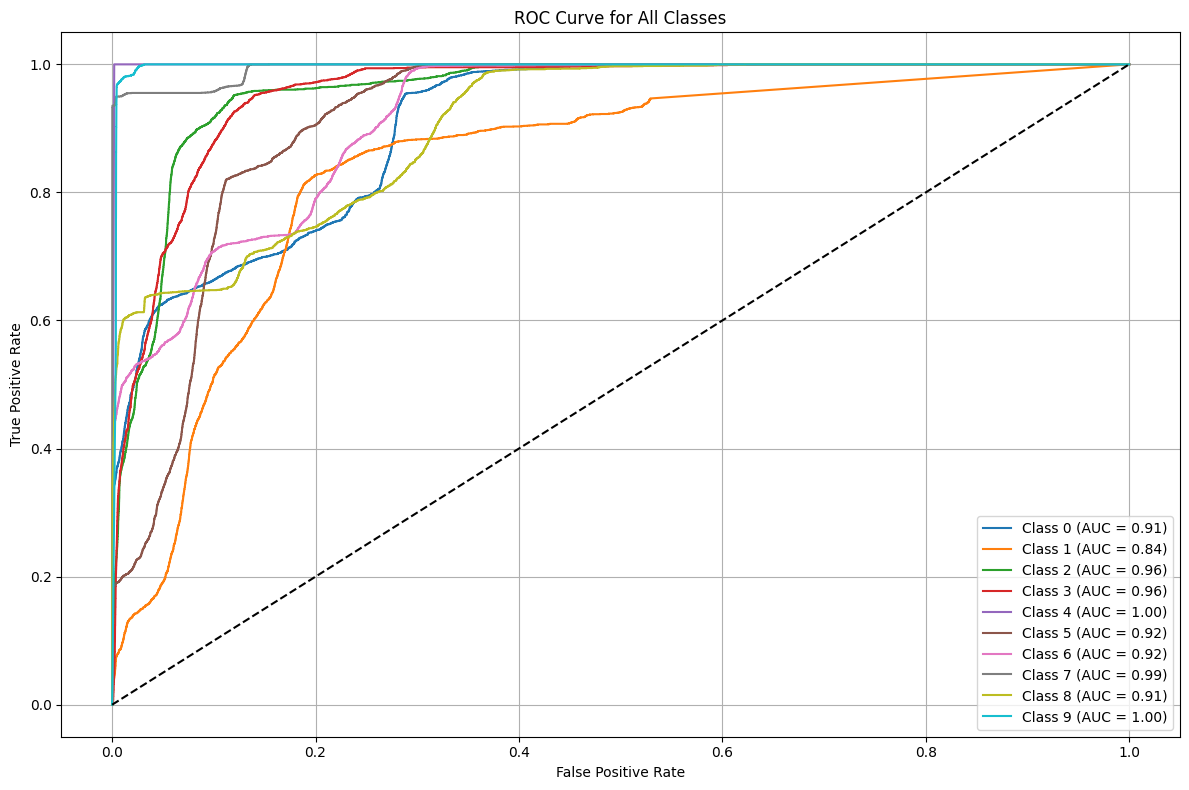


Model: Gradient Boosting (Training Data)
Training Accuracy: 1.00
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3751
           1       1.00      1.00      1.00      3701
           2       1.00      1.00      1.00      3600
           3       1.00      1.00      1.00      3751
           4       1.00      1.00      1.00      3701
           5       1.00      1.00      1.00      3701
           6       1.00      1.00      1.00      3701
           7       1.00      1.00      1.00      3701
           8       1.00      1.00      1.00      3701
           9       1.00      1.00      1.00      3701

    accuracy                           1.00     37009
   macro avg       1.00      1.00      1.00     37009
weighted avg       1.00      1.00      1.00     37009



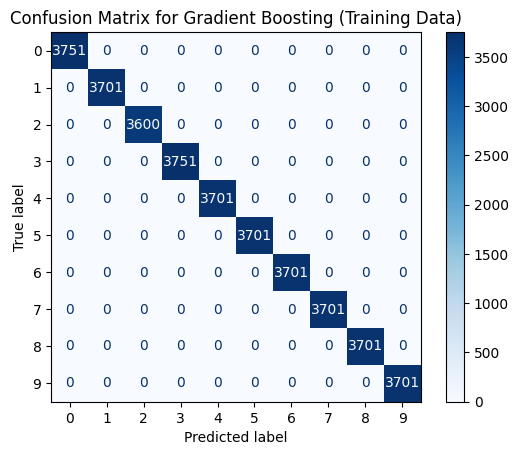


Model: Gradient Boosting (Test Data)
Test Accuracy: 0.91
Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.43      0.60      3438
           1       0.84      0.98      0.90      3134
           2       0.97      0.97      0.97      3035
           3       0.96      0.99      0.98      3121
           4       1.00      1.00      1.00      3134
           5       0.84      0.96      0.89      3134
           6       0.70      0.90      0.79      3134
           7       1.00      0.99      0.99      3134
           8       0.88      0.91      0.89      3134
           9       1.00      0.98      0.99      3134

    accuracy                           0.91     31532
   macro avg       0.92      0.91      0.90     31532
weighted avg       0.92      0.91      0.90     31532



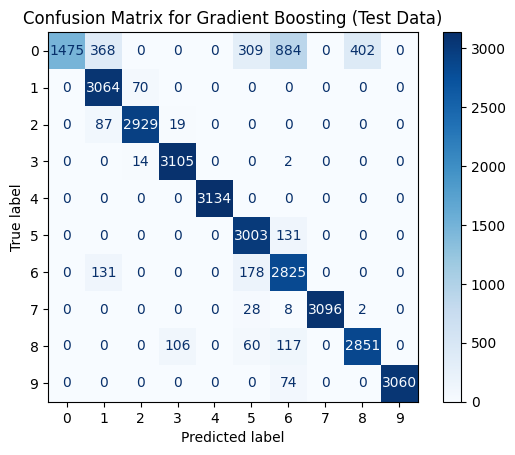

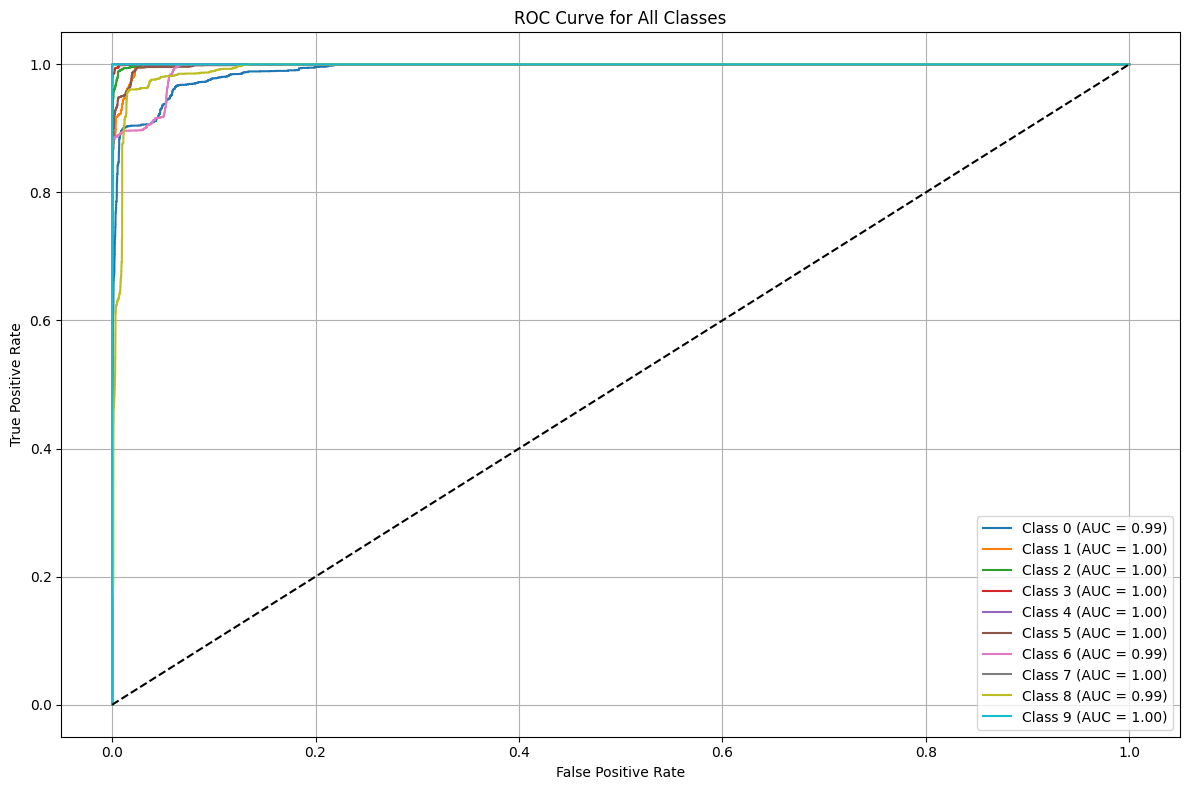


Model: AdaBoost (Training Data)
Training Accuracy: 0.23
Training Classification Report:
              precision    recall  f1-score   support

           0       0.13      1.00      0.23      3751
           1       0.00      0.00      0.00      3701
           2       0.00      0.00      0.00      3600
           3       0.00      0.00      0.00      3751
           4       1.00      1.00      1.00      3701
           5       0.17      0.19      0.18      3701
           6       0.00      0.00      0.00      3701
           7       0.75      0.13      0.22      3701
           8       0.00      0.00      0.00      3701
           9       0.78      0.01      0.01      3701

    accuracy                           0.23     37009
   macro avg       0.28      0.23      0.16     37009
weighted avg       0.28      0.23      0.16     37009



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


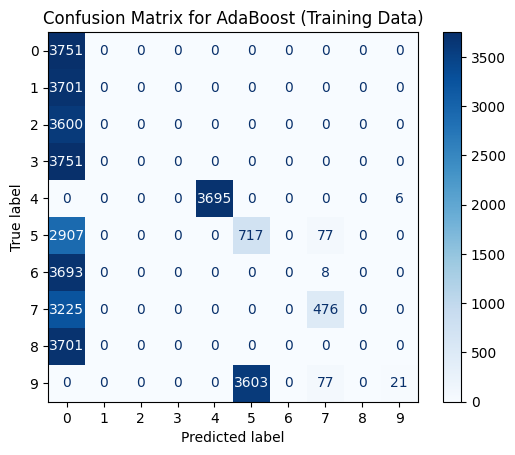


Model: AdaBoost (Test Data)
Test Accuracy: 0.25
Test Classification Report:
              precision    recall  f1-score   support

           0       0.14      1.00      0.25      3438
           1       0.00      0.00      0.00      3134
           2       0.00      0.00      0.00      3035
           3       0.00      0.00      0.00      3121
           4       1.00      0.99      1.00      3134
           5       0.15      0.17      0.16      3134
           6       0.00      0.00      0.00      3134
           7       0.95      0.24      0.39      3134
           8       0.00      0.00      0.00      3134
           9       0.00      0.00      0.00      3134

    accuracy                           0.25     31532
   macro avg       0.22      0.24      0.18     31532
weighted avg       0.22      0.25      0.18     31532



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


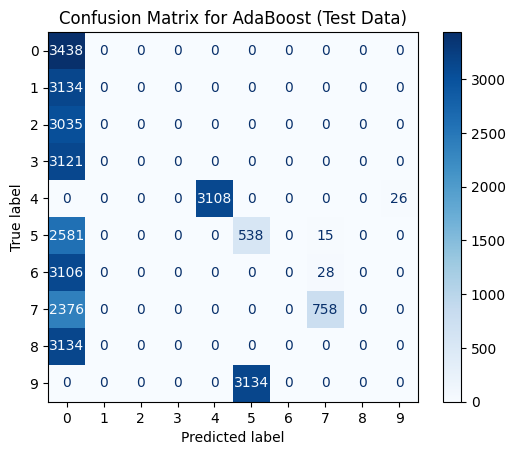

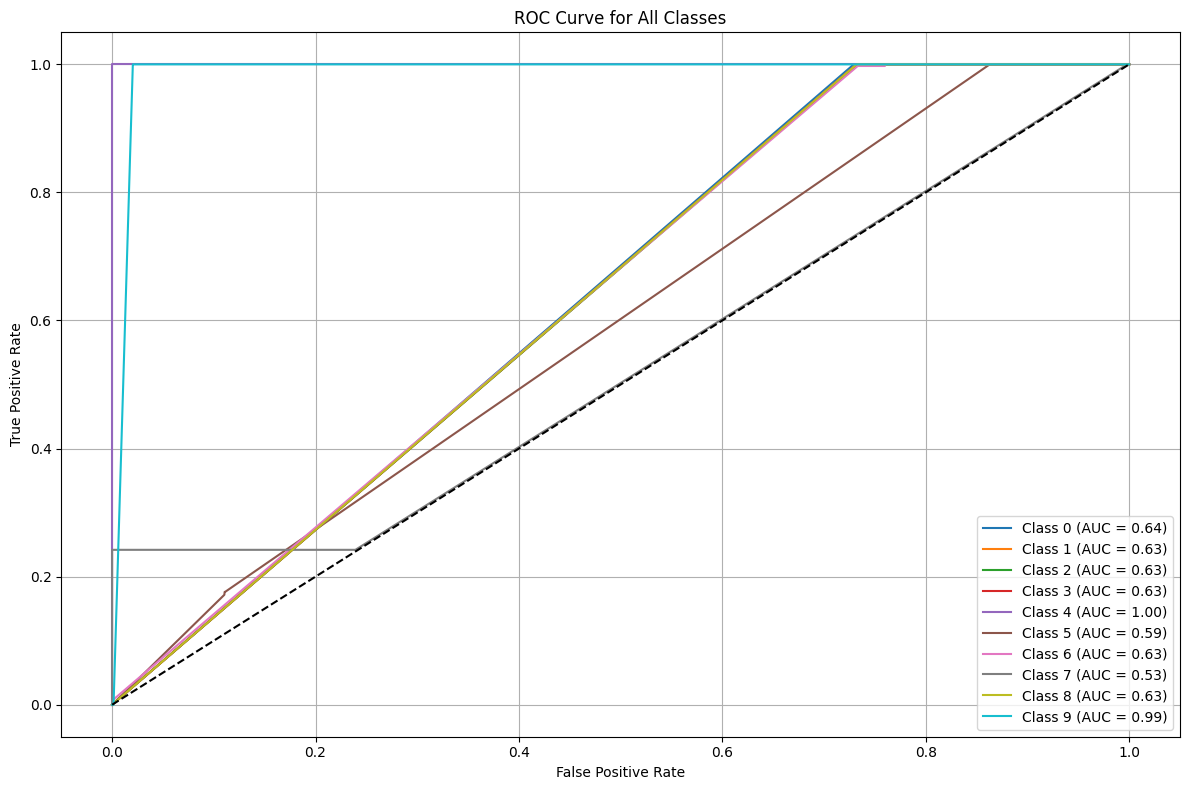


Model: Ridge Classifier (Training Data)
Training Accuracy: 0.80
Training Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      3751
           1       0.73      0.41      0.53      3701
           2       0.55      0.87      0.68      3600
           3       0.87      0.83      0.85      3751
           4       1.00      1.00      1.00      3701
           5       0.76      0.76      0.76      3701
           6       0.75      0.90      0.82      3701
           7       1.00      1.00      1.00      3701
           8       0.84      0.75      0.79      3701
           9       0.88      0.70      0.78      3701

    accuracy                           0.80     37009
   macro avg       0.81      0.80      0.79     37009
weighted avg       0.81      0.80      0.80     37009



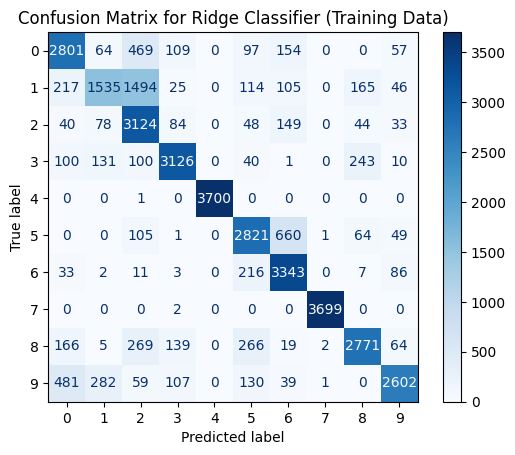


Model: Ridge Classifier (Test Data)
Test Accuracy: 0.75
Test Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.51      0.60      3438
           1       0.60      0.42      0.49      3134
           2       0.68      0.90      0.77      3035
           3       0.91      0.75      0.82      3121
           4       1.00      0.99      1.00      3134
           5       0.54      0.73      0.62      3134
           6       0.57      0.66      0.61      3134
           7       1.00      0.98      0.99      3134
           8       0.75      0.78      0.77      3134
           9       0.86      0.80      0.83      3134

    accuracy                           0.75     31532
   macro avg       0.76      0.75      0.75     31532
weighted avg       0.76      0.75      0.75     31532



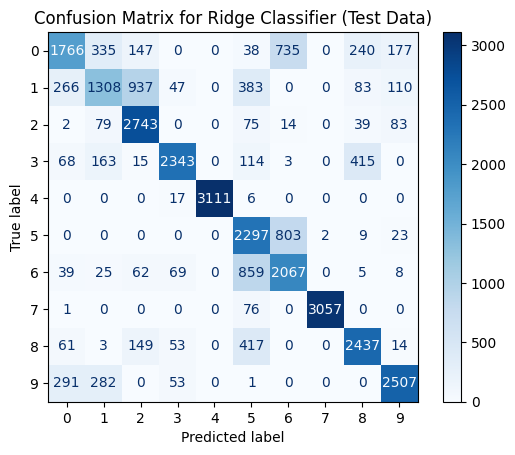


Model: XGBoost (Training Data)
Training Accuracy: 1.00
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3751
           1       1.00      1.00      1.00      3701
           2       1.00      1.00      1.00      3600
           3       1.00      1.00      1.00      3751
           4       1.00      1.00      1.00      3701
           5       1.00      1.00      1.00      3701
           6       1.00      1.00      1.00      3701
           7       1.00      1.00      1.00      3701
           8       1.00      1.00      1.00      3701
           9       1.00      1.00      1.00      3701

    accuracy                           1.00     37009
   macro avg       1.00      1.00      1.00     37009
weighted avg       1.00      1.00      1.00     37009



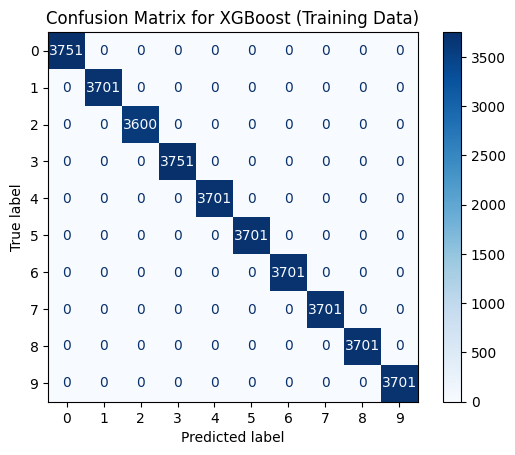


Model: XGBoost (Test Data)
Test Accuracy: 0.93
Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.62      0.76      3438
           1       0.83      0.95      0.89      3134
           2       0.94      0.97      0.96      3035
           3       0.96      1.00      0.98      3121
           4       1.00      1.00      1.00      3134
           5       0.89      0.98      0.93      3134
           6       0.87      0.91      0.89      3134
           7       1.00      1.00      1.00      3134
           8       0.85      0.94      0.89      3134
           9       1.00      0.96      0.98      3134

    accuracy                           0.93     31532
   macro avg       0.93      0.93      0.93     31532
weighted avg       0.94      0.93      0.93     31532



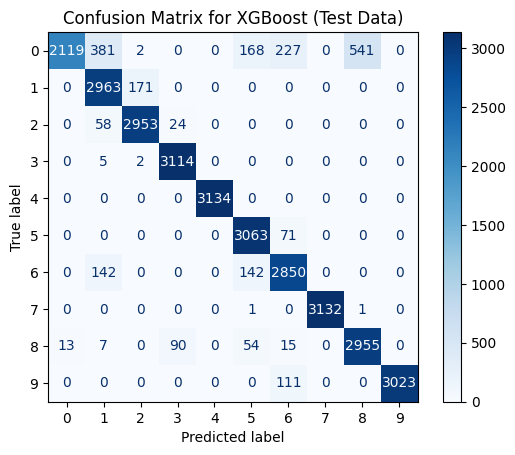

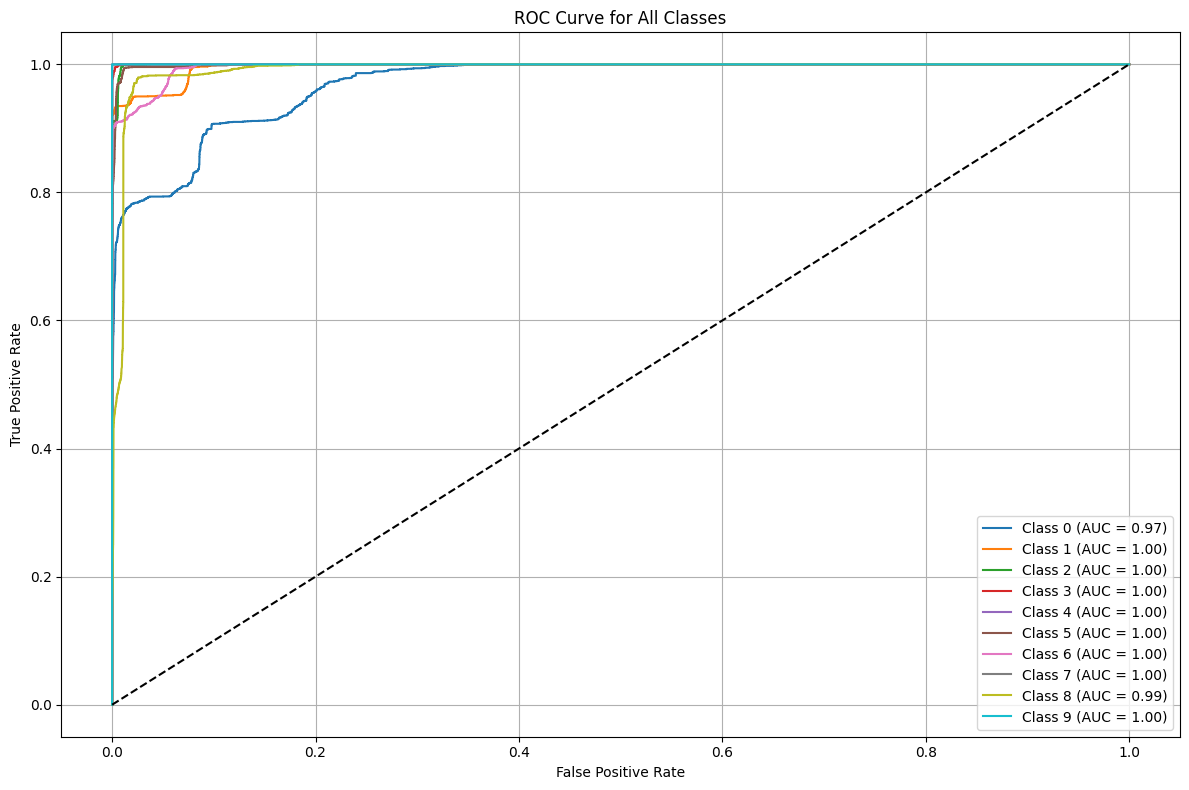


Best Model: Random Forest with Test Accuracy: 0.95


In [17]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, roc_auc_score
label_binarize = LabelBinarizer()
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Classifier": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Ridge Classifier": RidgeClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}
def train_and_evaluate_models(x_train, y_train, x_test, y_test):
    best_model = None
    best_model_name = ""
    highest_accuracy = 0
    
    for model_name, model in classifiers.items():
        model.fit(x_train, y_train)
        
        # Evaluate on training data
        y_train_pred = model.predict(x_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_cm = confusion_matrix(y_train, y_train_pred)
        
        print(f"\nModel: {model_name} (Training Data)")
        print(f"Training Accuracy: {train_accuracy:.2f}")
        train_report = classification_report(y_train, y_train_pred)
        print("Training Classification Report:")
        print(train_report)
        
        # Plot confusion matrix for training data
        train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=np.unique(y_train))
        train_disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {model_name} (Training Data)')
        plt.show()
        
        # Evaluate on test data
        y_test_pred = model.predict(x_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_cm = confusion_matrix(y_test, y_test_pred)
        
        print(f"\nModel: {model_name} (Test Data)")
        print(f"Test Accuracy: {test_accuracy:.2f}")
        test_report = classification_report(y_test, y_test_pred)
        print("Test Classification Report:")
        print(test_report)
        
        # Plot confusion matrix for test data
        test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=np.unique(y_test))
        test_disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {model_name} (Test Data)')
        plt.show()
        
        # Check for the best model
        if test_accuracy > highest_accuracy:
            highest_accuracy = test_accuracy
            best_model = model
            best_model_name = model_name

        # Check if model has predict_proba method
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(x_test)
            label_binarizer = LabelBinarizer()
            y_test_binarized = label_binarizer.fit_transform(y_test)
        
            roc_auc_scores = {}
            plt.figure(figsize=(12, 8))
            for i, class_label in enumerate(label_binarizer.classes_):
                fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
                auc = roc_auc_score(y_test_binarized[:, i], y_prob[:, i])
                roc_auc_scores[class_label] = auc
                plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {auc:.2f})")
        
            plt.plot([0, 1], [0, 1], 'k--')
            plt.title("ROC Curve for All Classes")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend(loc="lower right")
            plt.grid()
            plt.tight_layout()
            plt.show()

    
    print(f"\nBest Model: {best_model_name} with Test Accuracy: {highest_accuracy:.2f}")
    return best_model
# Run the function to train and evaluate all models
best_model = train_and_evaluate_models(x_train_scaled, y_train, x_test_scaled, y_test)

Average CV Training Accuracy: 0.9458
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3751
           1       0.97      0.99      0.98      3701
           2       0.99      0.99      0.99      3600
           3       1.00      1.00      1.00      3751
           4       1.00      1.00      1.00      3701
           5       0.99      1.00      0.99      3701
           6       1.00      0.99      1.00      3701
           7       1.00      1.00      1.00      3701
           8       1.00      0.99      1.00      3701
           9       1.00      1.00      1.00      3701

    accuracy                           0.99     37009
   macro avg       0.99      0.99      0.99     37009
weighted avg       0.99      0.99      0.99     37009



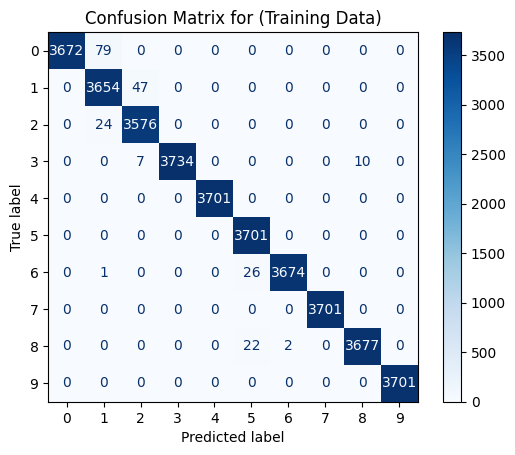

Test Accuracy: 0.93
Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.69      0.82      3438
           1       0.79      0.93      0.86      3134
           2       0.92      0.98      0.95      3035
           3       0.96      0.99      0.97      3121
           4       1.00      1.00      1.00      3134
           5       0.82      0.99      0.90      3134
           6       0.99      0.82      0.90      3134
           7       1.00      1.00      1.00      3134
           8       0.90      0.93      0.92      3134
           9       1.00      1.00      1.00      3134

    accuracy                           0.93     31532
   macro avg       0.94      0.93      0.93     31532
weighted avg       0.94      0.93      0.93     31532



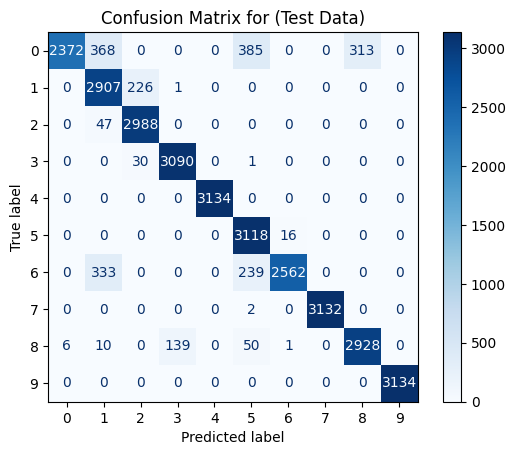

In [30]:
from sklearn.model_selection import cross_val_score

rf_model = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=100,
    max_depth=10,
    min_samples_split=48,
    min_samples_leaf=32,
    random_state=42,
)

cv_scores = cross_val_score(rf_model, x_train, y_train, cv=5, scoring='accuracy')
print(f'Average CV Training Accuracy: {np.mean(cv_scores):.4f}')

rf_model.fit(x_train, y_train)

y_train_pred = rf_model.predict(x_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_cm = confusion_matrix(y_train, y_train_pred)


train_report = classification_report(y_train, y_train_pred)
print("Training Classification Report:")
print(train_report)

# Plot confusion matrix for training data
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=np.unique(y_train))
train_disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for (Training Data)')
plt.show()

# Predict on test data
y_test_pred = rf_model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_cm = confusion_matrix(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")
test_report = classification_report(y_test, y_test_pred)
print("Test Classification Report:")
print(test_report)

# Plot confusion matrix for test data
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=np.unique(y_test))
test_disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for (Test Data)')
plt.show()

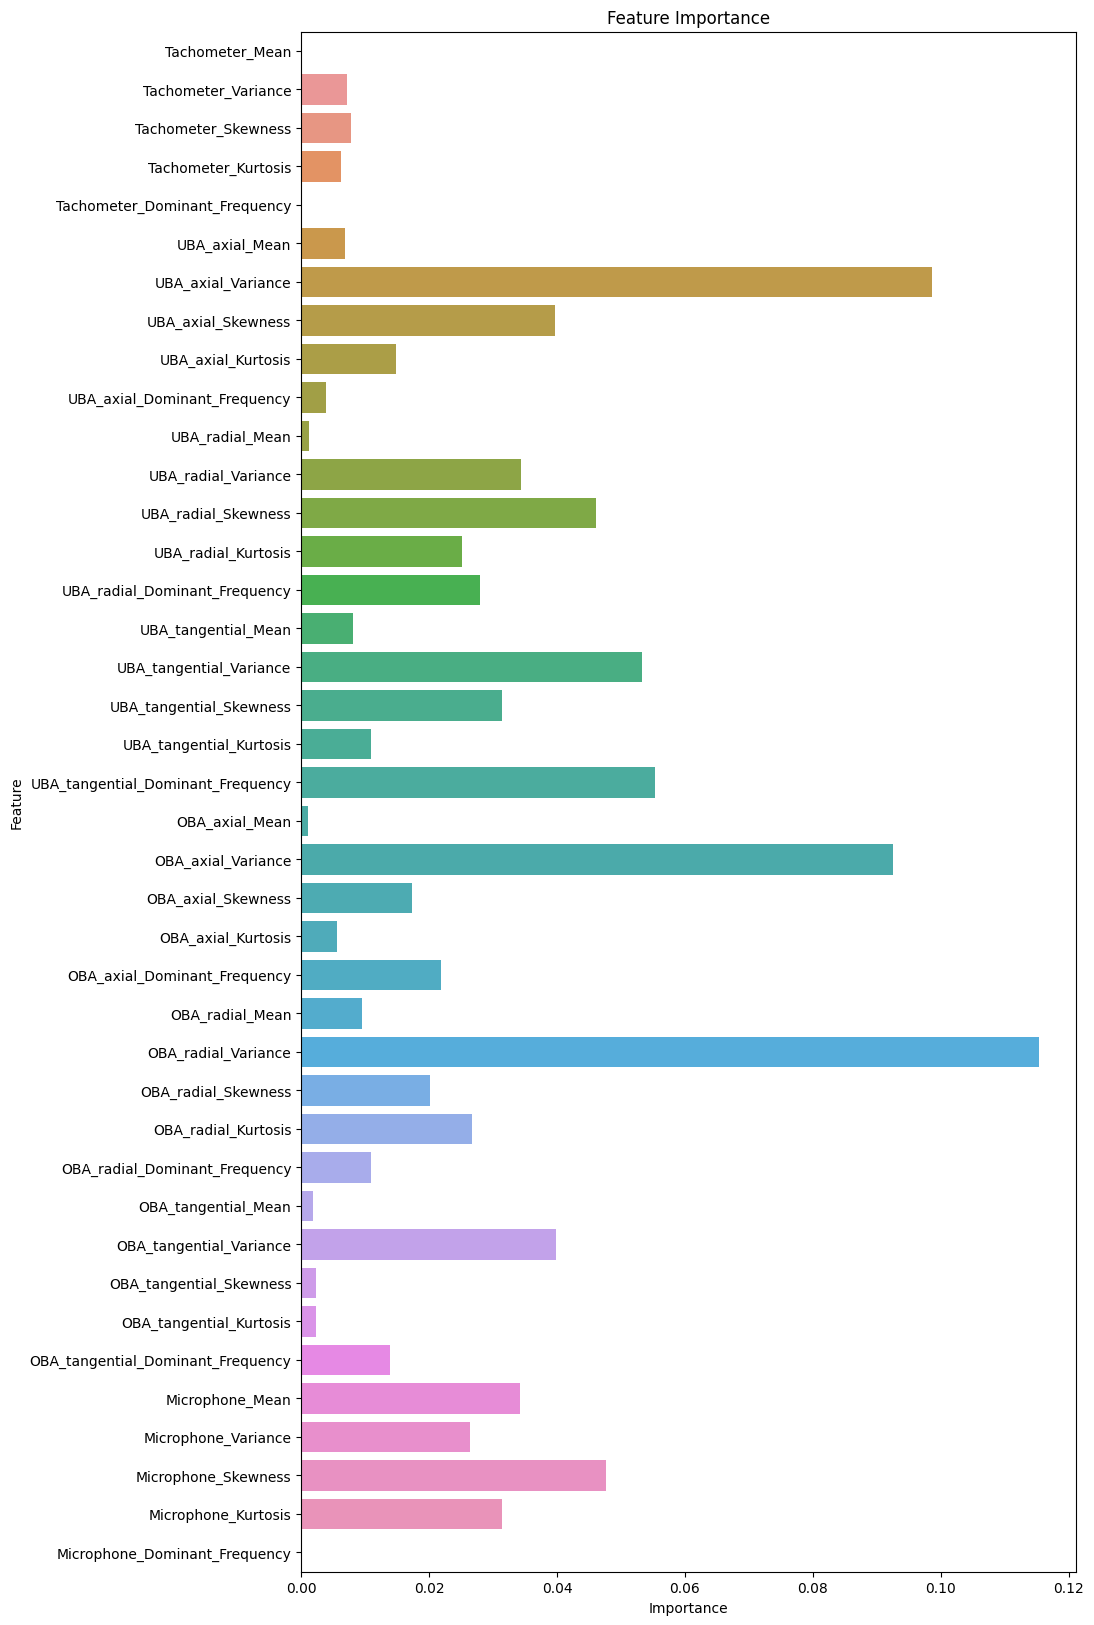

In [31]:
importances = rf_model.feature_importances_
feature_names = x_train.columns
plt.figure(figsize=(10, len(feature_names)*0.5))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

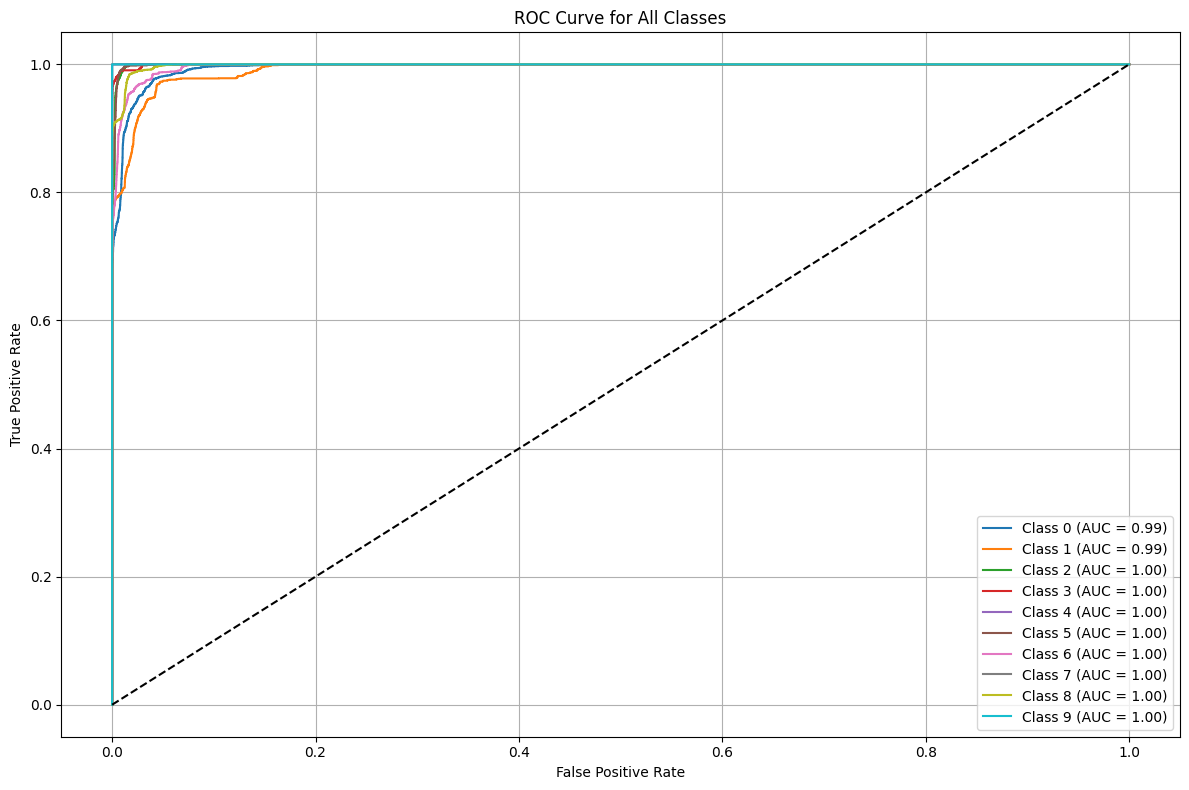

In [32]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

y_prob = rf_model.predict_proba(x_test)
classes = np.unique(y_test)
y_test_binarized = label_binarize(y_test, classes=classes)

roc_auc_scores = {}
plt.figure(figsize=(12, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    auc = roc_auc_score(y_test_binarized[:, i], y_prob[:, i])
    roc_auc_scores[class_label] = auc
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve for All Classes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()